# Train on W-jets

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import tensorflow.keras as keras
import tensorflow.keras.backend as K
# from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization
# from tensorflow.keras.layers import Conv1D
# from tensorflow.keras.layers import Flatten, Reshape, Lambda
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import Model

import os
import os.path as osp
import sys

import numpy as np
#from scipy import linalg as LA

import matplotlib
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from utils.tf_sinkhorn import ground_distance_tf_nograd, sinkhorn_knopp_tf_scaling_stabilized_class
import utils.VAE_model_tools_vm
from utils.VAE_model_tools_vm import build_and_compile_annealing_vae, betaVAEModel, reset_metrics

import pandas
import matplotlib.pyplot as plt

import h5py
import pickle


1 Physical GPUs, 1 Logical GPUs


In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def create_dir(dir_path):
    ''' Creates a directory (or nested directories) if they don't exist.
    '''
    if not osp.exists(dir_path):
        os.makedirs(dir_path)

    return dir_path

def ptetaphiE_to_Epxpypz(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = E
    newjets[:,:,1] = px
    newjets[:,:,2] = py
    newjets[:,:,3] = pz
    
    return newjets



def ptetaphiE_to_ptyphim(jets):
    pt = jets[:,:,0]
    eta = jets[:,:,1]
    phi = jets[:,:,2]
    E = jets[:,:,3]
    
    pz = pt * np.sinh(eta)
    y = 0.5*np.nan_to_num(np.log((E+pz)/(E-pz)))
    
    msqr = np.square(E)-np.square(pt)-np.square(pz)
    msqr[np.abs(msqr) < 1e-6] = 0
    m = np.sqrt(msqr)
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = y
    newjets[:,:,2] = phi
    newjets[:,:,3] = m
    
    return newjets
    
def ptyphim_to_ptetaphiE(jets):
    
    pt = jets[:,:,0]
    y = jets[:,:,1]
    phi = jets[:,:,2]
    m = jets[:,:,3]
    
    eta = np.nan_to_num(np.arcsinh(np.sinh(y)*np.sqrt(1+np.square(m/pt))))
    pz = pt * np.sinh(eta)
    E = np.sqrt(np.square(pz)+np.square(pt)+np.square(m))
    
    newjets = np.zeros(jets.shape)
    newjets[:,:,0] = pt
    newjets[:,:,1] = eta
    newjets[:,:,2] = phi
    newjets[:,:,3] = E
    
    return newjets
    
def center_jets_ptetaphiE(jets):
    cartesian_jets = ptetaphiE_to_Epxpypz(jets)
    sumjet_cartesian = np.sum(cartesian_jets,axis=1)
    
    sumjet_phi = np.arctan2(sumjet_cartesian[:,2],sumjet_cartesian[:,1])
    sumjet_y = 0.5*np.log((sumjet_cartesian[:,0] + sumjet_cartesian[:,-1])/(sumjet_cartesian[:,0] - sumjet_cartesian[:,-1]))
    
    ptyphim_jets = ptetaphiE_to_ptyphim(jets)
    #print(ptyphim_jets[:3,:,:])
    
    transformed_jets = np.copy(ptyphim_jets)
    transformed_jets[:,:,1] = ptyphim_jets[:,:,1] - sumjet_y[:,None]
    transformed_jets[:,:,2] = ptyphim_jets[:,:,2] - sumjet_phi[:,None]
    transformed_jets[:,:,2] = transformed_jets[:,:,2] + np.pi
    transformed_jets[:,:,2] = np.mod(transformed_jets[:,:,2],2*np.pi)
    transformed_jets[:,:,2] = transformed_jets[:,:,2] - np.pi

    transformed_jets[transformed_jets[:,:,0] == 0] = 0
    
    newjets = ptyphim_to_ptetaphiE(transformed_jets)
    return newjets
    

## Load and preprocess train/val data

In [4]:
# path to file
fn =  '/home/jcollins/projects/EMD_VAE/in_data/monoW-data-parton.h5'
# fn =  '/media/jcollins/MAGIC!/monoW-data-3.h5'

# Option 1: Load everything into memory
df = pandas.read_hdf(fn,stop=1000000)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3)+sum(df.memory_usage(deep=True)) / (1024**3))

(1000000, 8)
Memory in GB: 0.1341104507446289


In [5]:
# Data file contains, for each event, 50 particles (with zero padding), each particle with pT, eta, phi, E.
data = df.values.reshape((-1,2,4))

# Normalize pTs so that HT = 1
HT = np.sum(data[:,:,0],axis=-1)
data[:,:,0] = data[:,:,0]/HT[:,None]
data[:,:,-1] = data[:,:,-1]/HT[:,None]

# Center jet (optional)
# data = center_jets_ptetaphiE(data)

# Inputs x to NN will be: pT, eta, cos(phi), sin(phi), log E
# Separated phi into cos and sin for continuity around full detector, so make things easier for NN.
# Also adding the log E is mainly because it seems like it should make things easier for NN, since there is an exponential spread in particle energies.
# Feel free to change these choices as desired. E.g. px, py might be equally as good as pt, sin, cos.
sig_input = np.zeros((len(data),2,5))
sig_input[:,:,:2] = data[:,:,:2]
sig_input[:,:,2] = np.cos(data[:,:,2])
sig_input[:,:,3] = np.sin(data[:,:,2])
sig_input[:,:,4] = np.log(data[:,:,3]+1e-8)


data_x = sig_input
# Event 'labels' y are [pT, eta, phi], which is used to calculate EMD to output which is also pT, eta, phi.
data_y = data[:,:,:3]


train_x = data_x[:500000]
train_y = data_y[:500000]
valid_x = data_x[500000:600000]
valid_y = data_y[500000:600000]

In [18]:
output_dir = './data/'

experiment_name = 'W-parton-uncentered-vm-3'
train_output_dir = create_dir(osp.join(output_dir, experiment_name))
vae, encoder, decoder = build_and_compile_annealing_vae(optimizer=keras.optimizers.Adam(lr=0.001,clipnorm=0.1),
                                    encoder_conv_layers = [2048,1024,1024,1024],
                                    dense_size = [2048,1024,1024,512],
                                    decoder = [4096,2048,1024,1024,512],
                                    numItermaxinner = 10,   # EMD approximation params
                                    numIter=10,
                                    reg_init = 1.,
                                    reg_final = 0.01,
                                    stopThr=1e-3,
                                    num_inputs=5,           # Size of x (e.g. pT, eta, sin, cos, log E)
                                    num_particles_in=2,
                                    latent_dim = 2,
                                    latent_dim_vm = 1,
                                    verbose=0,
                                    dropout = 0.2,
                                    renorm_clip = {'rmin':5.,'rmax':5.,'dmax':5.})    # Num particles per event.

batch_size=100
save_period=2

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=0)
modelcheckpoint = keras.callbacks.ModelCheckpoint(train_output_dir + '/model_weights_{epoch:02d}.hdf5', save_freq = save_period*5000, save_weights_only=True)
reset_metrics_inst = reset_metrics()

callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,
            modelcheckpoint,
            reset_metrics_inst]


# Need to train on at least one example before model params can be loaded for annoying reasons.

history = vae.fit(x=train_x[:10], y=train_y[:10], batch_size=batch_size,
                epochs=1,verbose=1,#initial_epoch=int(vae.optimizer.iterations/numbatches),
                validation_data = (valid_x[:10],valid_y[:10]),
                callbacks = callbacks
              )

Model: "VAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 2, 5)]       0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 2, 2048)      12288       inputs[0][0]                     
__________________________________________________________________________________________________
re_lu_26 (ReLU)                 (None, 2, 2048)      0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 2, 2048)      0           re_lu_26[0][0]                   
________________________________________________________________________________________________

1/1 [==============================] - 1s 646ms/step - loss: 95.2586 - recon_loss: 3.5033 - KL loss: 92.5854 - KL VM loss: 0.9216 - beta: 1.0000 - alpha: 1.0000 - val_loss: 4.3783 - val_recon_loss: 4.4232 - val_KL loss: 1.0834 - val_KL VM loss: 1.0834


In [15]:
batch_size

100

In [7]:
betas = np.concatenate((np.logspace(1.,-1,11),
                       np.flip(np.logspace(1,-1,11))[1:],
                       np.logspace(1.,-1,11)[1:],
                       np.flip(np.logspace(1,-1,11))[1:]))
print(betas)

[10.          6.30957344  3.98107171  2.51188643  1.58489319  1.
  0.63095734  0.39810717  0.25118864  0.15848932  0.1         0.15848932
  0.25118864  0.39810717  0.63095734  1.          1.58489319  2.51188643
  3.98107171  6.30957344 10.          6.30957344  3.98107171  2.51188643
  1.58489319  1.          0.63095734  0.39810717  0.25118864  0.15848932
  0.1         0.15848932  0.25118864  0.39810717  0.63095734  1.
  1.58489319  2.51188643  3.98107171  6.30957344 10.        ]


In [8]:
np.logspace(1.,-1,21)

array([10.        ,  7.94328235,  6.30957344,  5.01187234,  3.98107171,
        3.16227766,  2.51188643,  1.99526231,  1.58489319,  1.25892541,
        1.        ,  0.79432823,  0.63095734,  0.50118723,  0.39810717,
        0.31622777,  0.25118864,  0.19952623,  0.15848932,  0.12589254,
        0.1       ])

[]

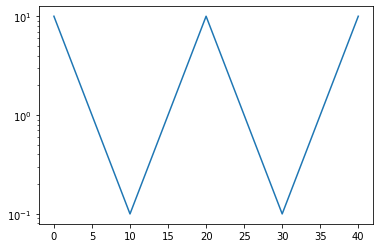

In [9]:
plt.plot(betas)
plt.semilogy()

In [21]:
betas[18]

3.9810717055349722

In [20]:
beta = 4e+00
vae.load_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

In [ ]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10
# init_epoch=0

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=4, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in betas[2:]:
    
    print("\n Changing beta to", beta)
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
#             modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,1e-4)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')


 Changing beta to 3.9810717055349722
Epoch 191/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1220 - recon_loss: 3.7663 - KL loss: 3.7603e-05 - KL VM loss: 0.0031 - beta: 3.9811 - alpha: 1.0000 - val_loss: 0.1293 - val_recon_loss: 3.9004 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031
Epoch 192/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1302 - recon_loss: 3.7681 - KL loss: 0.0218 - KL VM loss: 0.0032 - beta: 3.9811 - alpha: 1.0000 - val_loss: 0.1287 - val_recon_loss: 3.8803 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031
Epoch 193/10000
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1222 - recon_loss: 3.7741 - KL loss: 2.7862e-05 - KL VM loss: 0.0031 - beta: 3.9811 - alpha: 1.0000 - val_loss: 0.1292 - val_recon_loss: 3.8963 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031
Epoch 194/10000
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1230 - recon_loss: 3.7696 - KL loss: 6.7177e-04 - KL 

In [23]:
vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

In [11]:
vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

In [79]:
betas = np.concatenate((np.logspace(1.,-1,21)[7:],
                       np.flip(np.logspace(1,-1,11))[1:],
                       np.logspace(1.,-1,11)[1:],
                       np.flip(np.logspace(1,-1,11))[1:]))
print(betas)

[ 1.99526231  1.58489319  1.25892541  1.          0.79432823  0.63095734
  0.50118723  0.39810717  0.31622777  0.25118864  0.19952623  0.15848932
  0.12589254  0.1         0.15848932  0.25118864  0.39810717  0.63095734
  1.          1.58489319  2.51188643  3.98107171  6.30957344 10.
  6.30957344  3.98107171  2.51188643  1.58489319  1.          0.63095734
  0.39810717  0.25118864  0.15848932  0.1         0.15848932  0.25118864
  0.39810717  0.63095734  1.          1.58489319  2.51188643  3.98107171
  6.30957344 10.        ]


In [80]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10
init_epoch=0

reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=4, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=6, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in betas:
    print("\n Setting beta to", beta)
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
#             modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,1e-4)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
#     vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')


 Setting beta to 1.9952623149688793
Epoch 1/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4937 - recon_loss: 3.7788 - KL loss: 0.0323 - KL VM loss: 0.0167 - beta: 1.9953 - alpha: 1.0000 - val_loss: 0.4945 - val_recon_loss: 3.8693 - val_KL loss: 0.0043 - val_KL VM loss: 0.0043
Epoch 2/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4825 - recon_loss: 3.7868 - KL loss: 0.0042 - KL VM loss: 0.0033 - beta: 1.9953 - alpha: 1.0000 - val_loss: 0.4944 - val_recon_loss: 3.8860 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031
Epoch 3/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4786 - recon_loss: 3.7658 - KL loss: 0.0027 - KL VM loss: 0.0032 - beta: 1.9953 - alpha: 1.0000 - val_loss: 0.4947 - val_recon_loss: 3.8827 - val_KL loss: 0.0035 - val_KL VM loss: 0.0035
Epoch 4/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 0.4794 - recon_loss: 3.7760 - KL loss: 0.0021 - KL VM loss: 0.0032 - bet

Epoch 26/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 1.1911 - recon_loss: 3.7644 - KL loss: 4.0446e-04 - KL VM loss: 0.0031 - beta: 1.2589 - alpha: 1.0000 - val_loss: 1.2319 - val_recon_loss: 3.8850 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031
Epoch 27/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 1.1951 - recon_loss: 3.7769 - KL loss: 3.9802e-04 - KL VM loss: 0.0031 - beta: 1.2589 - alpha: 1.0000 - val_loss: 1.2326 - val_recon_loss: 3.8871 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031_loss: 3.7778 - KL loss: 3.9809e-04 - KL VM loss: 0.0031 - beta: 1.

 Setting beta to 1.0
Epoch 27/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 1.8879 - recon_loss: 3.7687 - KL loss: 3.9012e-04 - KL VM loss: 0.0031 - beta: 1.0000 - alpha: 1.0000 - val_loss: 1.9474 - val_recon_loss: 3.8822 - val_KL loss: 0.0031 - val_KL VM loss: 0.0031
Epoch 28/10000
1000/1000 [==============================] - 29s 29ms/step - loss: 1.88

KeyboardInterrupt: 

[]

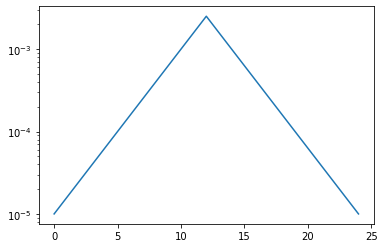

In [54]:
plt.plot(betas)
plt.semilogy()

In [56]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in betas:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
#             modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,1e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 5253/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 1669589.6191 - recon_loss: 1.6689e-04 - KL loss: 727.0038 - beta: 1.0000e-05 - val_loss: 1795552.2500 - val_recon_loss: 1.7949e-04 - val_KL loss: 689.0992 - val_beta: 1.0000e-05
Epoch 5254/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1613050.6335 - recon_loss: 1.6123e-04 - KL loss: 705.3825 - beta: 1.0000e-05 - val_loss: 1789260.7500 - val_recon_loss: 1.7886e-04 - val_KL loss: 690.1434 - val_beta: 1.0000e-05
Epoch 5255/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 1594401.8824 - recon_loss: 1.5937e-04 - KL loss: 704.6334 - beta: 1.0000e-05 - val_loss: 1766201.7500 - val_recon_loss: 1.7655e-04 - val_KL loss: 675.4101 - val_beta: 1.0000e-05
Epoch 5256/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1601507.6085 - recon_loss: 1.6008e-04 - KL loss: 699.3842 - beta: 1.0000e-05 - val_loss: 1829615.7500 - val_recon_loss: 1.8289e-04

Epoch 5280/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 610225.8239 - recon_loss: 1.5313e-04 - KL loss: 600.7452 - beta: 1.5849e-05 - val_loss: 724000.5000 - val_recon_loss: 1.8171e-04 - val_KL loss: 596.4158 - val_beta: 1.5849e-05
Epoch 5281/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 602156.5837 - recon_loss: 1.5110e-04 - KL loss: 599.7987 - beta: 1.5849e-05 - val_loss: 685870.8125 - val_recon_loss: 1.7213e-04 - val_KL loss: 594.0389 - val_beta: 1.5849e-05
Epoch 5282/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 605967.5826 - recon_loss: 1.5206e-04 - KL loss: 598.6597 - beta: 1.5849e-05 - val_loss: 724084.8125 - val_recon_loss: 1.8173e-04 - val_KL loss: 598.3728 - val_beta: 1.5849e-05
Epoch 5283/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 603684.6718 - recon_loss: 1.5149e-04 - KL loss: 602.9632 - beta: 1.5849e-05 - val_loss: 707715.0000 - val_recon_loss: 1.7762e-04 - val_K

1000/1000 [==============================] - 58s 58ms/step - loss: 95272.2791 - recon_loss: 1.5017e-04 - KL loss: 523.4447 - beta: 3.9811e-05 - val_loss: 109208.8906 - val_recon_loss: 1.7228e-04 - val_KL loss: 509.8805 - val_beta: 3.9811e-05
Epoch 5308/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 95012.9091 - recon_loss: 1.4978e-04 - KL loss: 505.0115 - beta: 3.9811e-05 - val_loss: 107502.0859 - val_recon_loss: 1.6960e-04 - val_KL loss: 489.7235 - val_beta: 3.9811e-05
Epoch 5309/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 96442.2236 - recon_loss: 1.5208e-04 - KL loss: 488.2570 - beta: 3.9811e-05 - val_loss: 111044.1172 - val_recon_loss: 1.7523e-04 - val_KL loss: 483.3026 - val_beta: 3.9811e-05
Epoch 5310/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 97179.0026 - recon_loss: 1.5327e-04 - KL loss: 474.4754 - beta: 3.9811e-05 - val_loss: 107453.6016 - val_recon_loss: 1.6957e-04 - val_KL loss: 464.4773 - va

1000/1000 [==============================] - 59s 59ms/step - loss: 36640.8287 - recon_loss: 1.4428e-04 - KL loss: 398.9831 - beta: 6.3096e-05 - val_loss: 40353.0898 - val_recon_loss: 1.5905e-04 - val_KL loss: 402.7389 - val_beta: 6.3096e-05
Epoch 5366/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 36286.1945 - recon_loss: 1.4287e-04 - KL loss: 399.0514 - beta: 6.3096e-05 - val_loss: 40198.4180 - val_recon_loss: 1.5842e-04 - val_KL loss: 404.2502 - val_beta: 6.3096e-05
Epoch 5367/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 36636.9507 - recon_loss: 1.4426e-04 - KL loss: 399.9033 - beta: 6.3096e-05 - val_loss: 40052.9492 - val_recon_loss: 1.5784e-04 - val_KL loss: 405.6031 - val_beta: 6.3096e-05
Epoch 5368/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 36850.3383 - recon_loss: 1.4510e-04 - KL loss: 401.7549 - beta: 6.3096e-05 - val_loss: 40181.5352 - val_recon_loss: 1.5835e-04 - val_KL loss: 405.0958 - val_be

Epoch 5418/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 1105.2600 - recon_loss: 1.5591e-04 - KL loss: 121.5607 - beta: 3.9811e-04 - val_loss: 1336.3907 - val_recon_loss: 1.9264e-04 - val_KL loss: 120.9202 - val_beta: 3.9811e-04
Epoch 5419/10000
 999/1000 [============================>.] - ETA: 0s - loss: 1117.9997 - recon_loss: 1.5780e-04 - KL loss: 122.3797 - beta: 3.9811e-04
Epoch 05419: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
1000/1000 [==============================] - 59s 59ms/step - loss: 1118.0156 - recon_loss: 1.5780e-04 - KL loss: 122.3789 - beta: 3.9811e-04 - val_loss: 1371.3956 - val_recon_loss: 1.9854e-04 - val_KL loss: 118.7236 - val_beta: 3.9811e-04
Epoch 5420/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 1107.4640 - recon_loss: 1.5636e-04 - KL loss: 120.9005 - beta: 3.9811e-04 - val_loss: 1468.4768 - val_recon_loss: 2.1372e-04 - val_KL loss: 119.9816 - val_beta: 3.9811e-04
Epoch 5421/10000

Epoch 5476/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 229.3198 - recon_loss: 1.6162e-04 - KL loss: 67.6967 - beta: 0.0010 - val_loss: 270.0468 - val_recon_loss: 2.0748e-04 - val_KL loss: 62.5680 - val_beta: 0.0010
Epoch 5477/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 229.6943 - recon_loss: 1.6743e-04 - KL loss: 62.2683 - beta: 0.0010 - val_loss: 261.6338 - val_recon_loss: 2.0106e-04 - val_KL loss: 60.5773 - val_beta: 0.0010
Epoch 5478/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 229.4995 - recon_loss: 1.6908e-04 - KL loss: 60.4210 - beta: 0.0010 - val_loss: 253.0796 - val_recon_loss: 1.9365e-04 - val_KL loss: 59.4335 - val_beta: 0.0010
Epoch 5479/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 230.1753 - recon_loss: 1.7080e-04 - KL loss: 59.3755 - beta: 0.0010 - val_loss: 256.1212 - val_recon_loss: 1.9791e-04 - val_KL loss: 58.2146 - val_beta: 0.0010
Epoch 5480/10000
1000/10

Epoch 5508/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 216.1355 - recon_loss: 1.6561e-04 - KL loss: 50.5234 - beta: 0.0010 - val_loss: 237.1612 - val_recon_loss: 1.8655e-04 - val_KL loss: 50.6142 - val_beta: 0.0010
Epoch 5509/10000
1000/1000 [==============================] - ETA: 0s - loss: 214.4907 - recon_loss: 1.6400e-04 - KL loss: 50.4902 - beta: 0.0010
Epoch 05509: ReduceLROnPlateau reducing learning rate to 3.162277652184396e-07.
1000/1000 [==============================] - 59s 59ms/step - loss: 214.4917 - recon_loss: 1.6400e-04 - KL loss: 50.4902 - beta: 0.0010 - val_loss: 239.5420 - val_recon_loss: 1.8911e-04 - val_KL loss: 50.4290 - val_beta: 0.0010
Epoch 5509/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 116.0457 - recon_loss: 1.8105e-04 - KL loss: 43.9695 - beta: 0.0016 - val_loss: 124.1311 - val_recon_loss: 2.0858e-04 - val_KL loss: 41.0929 - val_beta: 0.0016
Epoch 5510/10000
1000/1000 [==============================]

1000/1000 [==============================] - 58s 58ms/step - loss: 59.7612 - recon_loss: 2.1936e-04 - KL loss: 24.9945 - beta: 0.0025 - val_loss: 65.2166 - val_recon_loss: 2.5233e-04 - val_KL loss: 25.2250 - val_beta: 0.0025
Epoch 5569/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 59.7387 - recon_loss: 2.1920e-04 - KL loss: 24.9980 - beta: 0.0025 - val_loss: 61.7553 - val_recon_loss: 2.3447e-04 - val_KL loss: 24.5944 - val_beta: 0.0025
Epoch 5570/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 59.6074 - recon_loss: 2.1935e-04 - KL loss: 24.8424 - beta: 0.0025 - val_loss: 59.7872 - val_recon_loss: 2.2209e-04 - val_KL loss: 24.5888 - val_beta: 0.0025
Epoch 5571/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 59.6015 - recon_loss: 2.1894e-04 - KL loss: 24.9014 - beta: 0.0025 - val_loss: 61.5341 - val_recon_loss: 2.3370e-04 - val_KL loss: 24.4951 - val_beta: 0.0025
Epoch 5572/10000
1000/1000 [=====================

Epoch 5598/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 106.3919 - recon_loss: 1.8771e-04 - KL loss: 31.6651 - beta: 0.0016 - val_loss: 110.8397 - val_recon_loss: 1.9927e-04 - val_KL loss: 31.5077 - val_beta: 0.0016
Epoch 5599/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 105.9044 - recon_loss: 1.8639e-04 - KL loss: 31.7007 - beta: 0.0016 - val_loss: 118.7605 - val_recon_loss: 2.1915e-04 - val_KL loss: 31.5149 - val_beta: 0.0016
Epoch 5600/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 105.7353 - recon_loss: 1.8577e-04 - KL loss: 31.7778 - beta: 0.0016 - val_loss: 117.8394 - val_recon_loss: 2.1699e-04 - val_KL loss: 31.4555 - val_beta: 0.0016
Epoch 5601/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 106.2108 - recon_loss: 1.8701e-04 - KL loss: 31.7595 - beta: 0.0016 - val_loss: 116.3658 - val_recon_loss: 2.1335e-04 - val_KL loss: 31.4308 - val_beta: 0.0016
Epoch 5602/10000
1000/10

1000/1000 [==============================] - 58s 58ms/step - loss: 466.3461 - recon_loss: 1.6590e-04 - KL loss: 49.6302 - beta: 6.3096e-04 - val_loss: 511.1614 - val_recon_loss: 1.8351e-04 - val_KL loss: 50.2005 - val_beta: 6.3096e-04
Epoch 5627/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 462.7946 - recon_loss: 1.6426e-04 - KL loss: 50.1812 - beta: 6.3096e-04 - val_loss: 490.8061 - val_recon_loss: 1.7543e-04 - val_KL loss: 50.1395 - val_beta: 6.3096e-04
Epoch 5628/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 464.5603 - recon_loss: 1.6482e-04 - KL loss: 50.5435 - beta: 6.3096e-04 - val_loss: 539.5032 - val_recon_loss: 1.9475e-04 - val_KL loss: 50.3045 - val_beta: 6.3096e-04
Epoch 5629/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 468.0493 - recon_loss: 1.6609e-04 - KL loss: 50.8561 - beta: 6.3096e-04 - val_loss: 509.1945 - val_recon_loss: 1.8275e-04 - val_KL loss: 50.1360 - val_beta: 6.3096e-04
Epoch 563

1000/1000 [==============================] - 59s 59ms/step - loss: 2545.2126 - recon_loss: 1.5512e-04 - KL loss: 86.6912 - beta: 2.5119e-04 - val_loss: 2812.2268 - val_recon_loss: 1.7198e-04 - val_KL loss: 86.6030 - val_beta: 2.5119e-04
Epoch 5654/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 2518.2794 - recon_loss: 1.5344e-04 - KL loss: 86.4763 - beta: 2.5119e-04 - val_loss: 2827.4055 - val_recon_loss: 1.7286e-04 - val_KL loss: 87.6805 - val_beta: 2.5119e-04
Epoch 5655/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 2549.7131 - recon_loss: 1.5533e-04 - KL loss: 87.9708 - beta: 2.5119e-04 - val_loss: 2814.7327 - val_recon_loss: 1.7193e-04 - val_KL loss: 89.8159 - val_beta: 2.5119e-04
Epoch 5656/10000
1000/1000 [==============================] - ETA: 0s - loss: 2604.0534 - recon_loss: 1.5870e-04 - KL loss: 88.7697 - beta: 2.5119e-04
Epoch 05656: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
1000/1000 [============

Epoch 5682/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 2450.2377 - recon_loss: 1.4898e-04 - KL loss: 88.9971 - beta: 2.5119e-04 - val_loss: 2709.2607 - val_recon_loss: 1.6535e-04 - val_KL loss: 88.6621 - val_beta: 2.5119e-04
Epoch 5683/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 2426.3738 - recon_loss: 1.4749e-04 - KL loss: 88.7871 - beta: 2.5119e-04 - val_loss: 2711.6995 - val_recon_loss: 1.6550e-04 - val_KL loss: 88.6443 - val_beta: 2.5119e-04
Epoch 5684/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 2448.4418 - recon_loss: 1.4889e-04 - KL loss: 88.6748 - beta: 2.5119e-04 - val_loss: 2724.3594 - val_recon_loss: 1.6630e-04 - val_KL loss: 88.6781 - val_beta: 2.5119e-04
Epoch 5685/10000
1000/1000 [==============================] - ETA: 0s - loss: 2426.4394 - recon_loss: 1.4751e-04 - KL loss: 88.5619 - beta: 2.5119e-04
Epoch 05685: ReduceLROnPlateau reducing learning rate to 3.1622774724297223e-08.
1000/1

Epoch 5709/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 15117.2750 - recon_loss: 1.4957e-04 - KL loss: 160.6579 - beta: 1.0000e-04 - val_loss: 17291.8691 - val_recon_loss: 1.7132e-04 - val_KL loss: 159.5261 - val_beta: 1.0000e-04
Epoch 5710/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 15046.8286 - recon_loss: 1.4885e-04 - KL loss: 162.1072 - beta: 1.0000e-04 - val_loss: 16719.5508 - val_recon_loss: 1.6557e-04 - val_KL loss: 162.1354 - val_beta: 1.0000e-04
Epoch 5711/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 14970.3170 - recon_loss: 1.4806e-04 - KL loss: 164.7021 - beta: 1.0000e-04 - val_loss: 16225.5391 - val_recon_loss: 1.6061e-04 - val_KL loss: 164.6063 - val_beta: 1.0000e-04
Epoch 5712/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 14966.9936 - recon_loss: 1.4799e-04 - KL loss: 167.7187 - beta: 1.0000e-04 - val_loss: 16090.4980 - val_recon_loss: 1.5921e-04 - val_KL loss: 

Epoch 5737/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 37982.3112 - recon_loss: 1.5023e-04 - KL loss: 246.6837 - beta: 6.3096e-05 - val_loss: 41677.4492 - val_recon_loss: 1.6494e-04 - val_KL loss: 247.3541 - val_beta: 6.3096e-05
Epoch 5738/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 37783.9837 - recon_loss: 1.4944e-04 - KL loss: 246.7959 - beta: 6.3096e-05 - val_loss: 43521.9844 - val_recon_loss: 1.7228e-04 - val_KL loss: 247.0612 - val_beta: 6.3096e-05
Epoch 5739/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 37381.8966 - recon_loss: 1.4784e-04 - KL loss: 246.5908 - beta: 6.3096e-05 - val_loss: 42523.1992 - val_recon_loss: 1.6830e-04 - val_KL loss: 248.3254 - val_beta: 6.3096e-05
Epoch 5740/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 37951.0926 - recon_loss: 1.5010e-04 - KL loss: 247.9267 - beta: 6.3096e-05 - val_loss: 40960.0703 - val_recon_loss: 1.6208e-04 - val_KL loss: 

1000/1000 [==============================] - 59s 59ms/step - loss: 223651.3843 - recon_loss: 1.4088e-04 - KL loss: 371.9450 - beta: 2.5119e-05 - val_loss: 250119.7500 - val_recon_loss: 1.5758e-04 - val_KL loss: 371.2731 - val_beta: 2.5119e-05
Epoch 5793/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 225867.8523 - recon_loss: 1.4228e-04 - KL loss: 372.1821 - beta: 2.5119e-05 - val_loss: 255912.8594 - val_recon_loss: 1.6124e-04 - val_KL loss: 369.9228 - val_beta: 2.5119e-05
Epoch 5794/10000
1000/1000 [==============================] - ETA: 0s - loss: 225280.3505 - recon_loss: 1.4191e-04 - KL loss: 370.2969 - beta: 2.5119e-05
Epoch 05794: ReduceLROnPlateau reducing learning rate to 3.162277652184396e-07.
1000/1000 [==============================] - 58s 58ms/step - loss: 225281.0898 - recon_loss: 1.4191e-04 - KL loss: 370.2974 - beta: 2.5119e-05 - val_loss: 261070.0312 - val_recon_loss: 1.6449e-04 - val_KL loss: 371.0625 - val_beta: 2.5119e-05
Epoch 5794/10000
100

Epoch 5820/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 570564.3226 - recon_loss: 1.4321e-04 - KL loss: 441.7551 - beta: 1.5849e-05 - val_loss: 603880.3125 - val_recon_loss: 1.5158e-04 - val_KL loss: 441.9325 - val_beta: 1.5849e-05
Epoch 5821/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 569890.3624 - recon_loss: 1.4304e-04 - KL loss: 441.1847 - beta: 1.5849e-05 - val_loss: 604144.0625 - val_recon_loss: 1.5164e-04 - val_KL loss: 441.4881 - val_beta: 1.5849e-05
Epoch 5822/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 570643.9435 - recon_loss: 1.4323e-04 - KL loss: 441.8489 - beta: 1.5849e-05 - val_loss: 603028.1875 - val_recon_loss: 1.5136e-04 - val_KL loss: 441.0775 - val_beta: 1.5849e-05
Epoch 5823/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 569385.8758 - recon_loss: 1.4291e-04 - KL loss: 440.7322 - beta: 1.5849e-05 - val_loss: 606147.0625 - val_recon_loss: 1.5215e-04 - val_K

Epoch 5848/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1429238.2922 - recon_loss: 1.4287e-04 - KL loss: 494.6115 - beta: 1.0000e-05 - val_loss: 1520548.8750 - val_recon_loss: 1.5201e-04 - val_KL loss: 497.0237 - val_beta: 1.0000e-05
Epoch 5849/10000
1000/1000 [==============================] - ETA: 0s - loss: 1400527.4684 - recon_loss: 1.4000e-04 - KL loss: 496.6633 - beta: 1.0000e-05
Epoch 05849: ReduceLROnPlateau reducing learning rate to 9.99999983430526e-07.
1000/1000 [==============================] - 58s 58ms/step - loss: 1400533.2255 - recon_loss: 1.4000e-04 - KL loss: 496.6642 - beta: 1.0000e-05 - val_loss: 1509164.6250 - val_recon_loss: 1.5087e-04 - val_KL loss: 500.7595 - val_beta: 1.0000e-05
Epoch 5850/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 1425116.3590 - recon_loss: 1.4246e-04 - KL loss: 502.1984 - beta: 1.0000e-05 - val_loss: 1497694.6250 - val_recon_loss: 1.4972e-04 - val_KL loss: 500.5880 - val_beta: 1.0000e-

[]

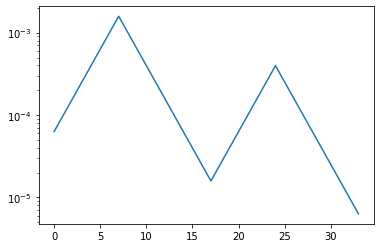

In [45]:
plt.plot(betas)
plt.semilogy()

In [47]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in betas:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
#             modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 4277/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 73914.4335 - recon_loss: 2.9333e-04 - KL loss: 233.2556 - beta: 6.3096e-05 - val_loss: 81207.3125 - val_recon_loss: 3.2242e-04 - val_KL loss: 220.1159 - val_beta: 6.3096e-05
Epoch 4278/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 74487.1938 - recon_loss: 2.9564e-04 - KL loss: 225.5300 - beta: 6.3096e-05 - val_loss: 92260.8359 - val_recon_loss: 3.6637e-04 - val_KL loss: 231.7334 - val_beta: 6.3096e-05
Epoch 4279/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 75256.3566 - recon_loss: 2.9870e-04 - KL loss: 225.9325 - beta: 6.3096e-05 - val_loss: 86923.5703 - val_recon_loss: 3.4512e-04 - val_KL loss: 233.0823 - val_beta: 6.3096e-05
Epoch 4280/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 83009.7690 - recon_loss: 3.2946e-04 - KL loss: 254.0937 - beta: 6.3096e-05 - val_loss: 103231.7266 - val_recon_loss: 4.1000e-04 - val_KL loss:

1000/1000 [==============================] - 59s 59ms/step - loss: 26382.6676 - recon_loss: 2.6165e-04 - KL loss: 218.1542 - beta: 1.0000e-04 - val_loss: 27582.9062 - val_recon_loss: 2.7366e-04 - val_KL loss: 216.5128 - val_beta: 1.0000e-04
Epoch 4336/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 26672.9099 - recon_loss: 2.6455e-04 - KL loss: 217.5944 - beta: 1.0000e-04 - val_loss: 27880.9043 - val_recon_loss: 2.7669e-04 - val_KL loss: 211.8913 - val_beta: 1.0000e-04
Epoch 4337/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 26319.9375 - recon_loss: 2.6104e-04 - KL loss: 215.6977 - beta: 1.0000e-04 - val_loss: 27296.3359 - val_recon_loss: 2.7078e-04 - val_KL loss: 218.4993 - val_beta: 1.0000e-04
Epoch 4338/10000
1000/1000 [==============================] - ETA: 0s - loss: 25916.7649 - recon_loss: 2.5698e-04 - KL loss: 219.0054 - beta: 1.0000e-04
Epoch 04338: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000

Epoch 4390/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 4005.7799 - recon_loss: 2.4558e-04 - KL loss: 113.5549 - beta: 2.5119e-04 - val_loss: 4122.2666 - val_recon_loss: 2.5298e-04 - val_KL loss: 112.8570 - val_beta: 2.5119e-04
Epoch 4391/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3967.4524 - recon_loss: 2.4321e-04 - KL loss: 112.8918 - beta: 2.5119e-04 - val_loss: 3987.9141 - val_recon_loss: 2.4456e-04 - val_KL loss: 111.8367 - val_beta: 2.5119e-04
Epoch 4392/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 3961.9593 - recon_loss: 2.4289e-04 - KL loss: 112.4313 - beta: 2.5119e-04 - val_loss: 4151.3301 - val_recon_loss: 2.5493e-04 - val_KL loss: 110.9773 - val_beta: 2.5119e-04
Epoch 4393/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3970.2016 - recon_loss: 2.4341e-04 - KL loss: 112.4555 - beta: 2.5119e-04 - val_loss: 4375.8950 - val_recon_loss: 2.6894e-04 - val_KL loss: 113.5263

1000/1000 [==============================] - 58s 58ms/step - loss: 311.1907 - recon_loss: 2.7060e-04 - KL loss: 40.5934 - beta: 0.0010 - val_loss: 321.0327 - val_recon_loss: 2.8101e-04 - val_KL loss: 40.0203 - val_beta: 0.0010
Epoch 4446/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 300.5617 - recon_loss: 2.6019e-04 - KL loss: 40.3697 - beta: 0.0010 - val_loss: 339.5599 - val_recon_loss: 2.9891e-04 - val_KL loss: 40.6494 - val_beta: 0.0010
Epoch 4447/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 306.8790 - recon_loss: 2.6659e-04 - KL loss: 40.2861 - beta: 0.0010 - val_loss: 305.8668 - val_recon_loss: 2.6613e-04 - val_KL loss: 39.7408 - val_beta: 0.0010
Epoch 4448/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 306.6380 - recon_loss: 2.6637e-04 - KL loss: 40.2665 - beta: 0.0010 - val_loss: 347.8137 - val_recon_loss: 3.0740e-04 - val_KL loss: 40.4138 - val_beta: 0.0010
Epoch 4449/10000
1000/1000 [=============

Epoch 4507/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 133.5888 - recon_loss: 2.6029e-04 - KL loss: 29.9650 - beta: 0.0016 - val_loss: 137.5383 - val_recon_loss: 2.7105e-04 - val_KL loss: 29.6324 - val_beta: 0.0016
Epoch 4508/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 133.0413 - recon_loss: 2.5895e-04 - KL loss: 29.9511 - beta: 0.0016 - val_loss: 137.0866 - val_recon_loss: 2.6964e-04 - val_KL loss: 29.7400 - val_beta: 0.0016
Epoch 4509/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 133.9986 - recon_loss: 2.6146e-04 - KL loss: 29.9094 - beta: 0.0016 - val_loss: 134.1930 - val_recon_loss: 2.6278e-04 - val_KL loss: 29.5795 - val_beta: 0.0016
Epoch 4510/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 134.1869 - recon_loss: 2.6179e-04 - KL loss: 29.9670 - beta: 0.0016 - val_loss: 136.8755 - val_recon_loss: 2.6953e-04 - val_KL loss: 29.5742 - val_beta: 0.0016
Epoch 4511/10000
1000/10

1000/1000 [==============================] - 58s 58ms/step - loss: 292.5692 - recon_loss: 2.5577e-04 - KL loss: 36.7978 - beta: 0.0010 - val_loss: 308.8798 - val_recon_loss: 2.7172e-04 - val_KL loss: 37.1591 - val_beta: 0.0010
Epoch 4538/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 294.0912 - recon_loss: 2.5721e-04 - KL loss: 36.8795 - beta: 0.0010 - val_loss: 346.4140 - val_recon_loss: 3.0890e-04 - val_KL loss: 37.5126 - val_beta: 0.0010
Epoch 4539/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 306.5018 - recon_loss: 2.6894e-04 - KL loss: 37.5652 - beta: 0.0010 - val_loss: 338.6946 - val_recon_loss: 3.0098e-04 - val_KL loss: 37.7149 - val_beta: 0.0010
Epoch 4540/10000
1000/1000 [==============================] - ETA: 0s - loss: 302.5660 - recon_loss: 2.6535e-04 - KL loss: 37.2150 - beta: 0.0010
Epoch 04540: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 58s 58ms/step

Epoch 4569/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 277.7595 - recon_loss: 2.4073e-04 - KL loss: 37.0324 - beta: 0.0010 - val_loss: 286.6957 - val_recon_loss: 2.4908e-04 - val_KL loss: 37.6123 - val_beta: 0.0010
Epoch 4570/10000
1000/1000 [==============================] - ETA: 0s - loss: 279.5449 - recon_loss: 2.4240e-04 - KL loss: 37.1487 - beta: 0.0010
Epoch 04570: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 58s 58ms/step - loss: 279.5451 - recon_loss: 2.4240e-04 - KL loss: 37.1487 - beta: 0.0010 - val_loss: 281.0164 - val_recon_loss: 2.4336e-04 - val_KL loss: 37.6582 - val_beta: 0.0010
Epoch 4570/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 831.2062 - recon_loss: 3.1367e-04 - KL loss: 43.2917 - beta: 6.3096e-04 - val_loss: 808.8658 - val_recon_loss: 3.0509e-04 - val_KL loss: 42.5143 - val_beta: 6.3096e-04
Epoch 4571/10000
1000/1000 [======================

1000/1000 [==============================] - 59s 59ms/step - loss: 606.3693 - recon_loss: 2.2407e-04 - KL loss: 43.5280 - beta: 6.3096e-04 - val_loss: 689.7249 - val_recon_loss: 2.5728e-04 - val_KL loss: 43.4701 - val_beta: 6.3096e-04
Epoch 4599/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 607.3523 - recon_loss: 2.2435e-04 - KL loss: 43.8078 - beta: 6.3096e-04 - val_loss: 678.9301 - val_recon_loss: 2.5261e-04 - val_KL loss: 44.3907 - val_beta: 6.3096e-04
Epoch 4600/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 607.1370 - recon_loss: 2.2417e-04 - KL loss: 44.0558 - beta: 6.3096e-04 - val_loss: 689.2209 - val_recon_loss: 2.5684e-04 - val_KL loss: 44.0756 - val_beta: 6.3096e-04
Epoch 4601/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 612.3579 - recon_loss: 2.2638e-04 - KL loss: 43.7214 - beta: 6.3096e-04 - val_loss: 685.1071 - val_recon_loss: 2.5508e-04 - val_KL loss: 44.3692 - val_beta: 6.3096e-04
Epoch 460

Epoch 4626/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 3924.8006 - recon_loss: 2.4310e-04 - KL loss: 71.9169 - beta: 2.5119e-04 - val_loss: 4506.8193 - val_recon_loss: 2.7951e-04 - val_KL loss: 76.9281 - val_beta: 2.5119e-04
Epoch 4627/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3938.9025 - recon_loss: 2.4397e-04 - KL loss: 72.2200 - beta: 2.5119e-04 - val_loss: 3973.8518 - val_recon_loss: 2.4637e-04 - val_KL loss: 69.2040 - val_beta: 2.5119e-04
Epoch 4628/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3751.2145 - recon_loss: 2.3233e-04 - KL loss: 69.0227 - beta: 2.5119e-04 - val_loss: 3921.2520 - val_recon_loss: 2.4303e-04 - val_KL loss: 69.4430 - val_beta: 2.5119e-04
Epoch 4629/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 3745.5072 - recon_loss: 2.3191e-04 - KL loss: 70.0450 - beta: 2.5119e-04 - val_loss: 4882.8853 - val_recon_loss: 3.0310e-04 - val_KL loss: 79.1189 - val_b

Epoch 4653/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 24701.3364 - recon_loss: 2.4571e-04 - KL loss: 130.6341 - beta: 1.0000e-04 - val_loss: 30401.8594 - val_recon_loss: 3.0244e-04 - val_KL loss: 157.5731 - val_beta: 1.0000e-04
Epoch 4654/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 24494.1806 - recon_loss: 2.4335e-04 - KL loss: 159.1488 - beta: 1.0000e-04 - val_loss: 25696.8613 - val_recon_loss: 2.5545e-04 - val_KL loss: 151.3886 - val_beta: 1.0000e-04
Epoch 4655/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 22764.8708 - recon_loss: 2.2610e-04 - KL loss: 155.1443 - beta: 1.0000e-04 - val_loss: 25211.3594 - val_recon_loss: 2.5049e-04 - val_KL loss: 162.0933 - val_beta: 1.0000e-04
Epoch 4656/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 23754.8724 - recon_loss: 2.3591e-04 - KL loss: 163.8965 - beta: 1.0000e-04 - val_loss: 25973.4922 - val_recon_loss: 2.5807e-04 - val_KL loss: 

1000/1000 [==============================] - 59s 59ms/step - loss: 135288.9193 - recon_loss: 2.1390e-04 - KL loss: 327.1476 - beta: 3.9811e-05 - val_loss: 142395.6250 - val_recon_loss: 2.2516e-04 - val_KL loss: 328.2403 - val_beta: 3.9811e-05
Epoch 4710/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 132226.4634 - recon_loss: 2.0905e-04 - KL loss: 324.2990 - beta: 3.9811e-05 - val_loss: 142200.5469 - val_recon_loss: 2.2485e-04 - val_KL loss: 332.1836 - val_beta: 3.9811e-05
Epoch 4711/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 134706.5604 - recon_loss: 2.1298e-04 - KL loss: 326.1742 - beta: 3.9811e-05 - val_loss: 157597.3594 - val_recon_loss: 2.4925e-04 - val_KL loss: 330.3501 - val_beta: 3.9811e-05
Epoch 4712/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 164766.3158 - recon_loss: 2.6054e-04 - KL loss: 375.2385 - beta: 3.9811e-05 - val_loss: 166709.4531 - val_recon_loss: 2.6363e-04 - val_KL loss: 367.3263 

Epoch 4739/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 118403.7992 - recon_loss: 1.8707e-04 - KL loss: 372.4973 - beta: 3.9811e-05 - val_loss: 122567.9688 - val_recon_loss: 1.9365e-04 - val_KL loss: 385.4078 - val_beta: 3.9811e-05
Epoch 4740/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 120282.0911 - recon_loss: 1.9004e-04 - KL loss: 375.6560 - beta: 3.9811e-05 - val_loss: 120851.5469 - val_recon_loss: 1.9094e-04 - val_KL loss: 377.4134 - val_beta: 3.9811e-05
Epoch 4741/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 118724.7948 - recon_loss: 1.8758e-04 - KL loss: 371.5041 - beta: 3.9811e-05 - val_loss: 120805.9609 - val_recon_loss: 1.9086e-04 - val_KL loss: 378.4872 - val_beta: 3.9811e-05
Epoch 4742/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 117611.5146 - recon_loss: 1.8581e-04 - KL loss: 370.1667 - beta: 3.9811e-05 - val_loss: 119202.1406 - val_recon_loss: 1.8832e-04 - val_K

Epoch 4768/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 322847.9987 - recon_loss: 2.0345e-04 - KL loss: 404.9993 - beta: 2.5119e-05 - val_loss: 527208.7500 - val_recon_loss: 3.3239e-04 - val_KL loss: 411.3291 - val_beta: 2.5119e-05
Epoch 4769/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 378249.7908 - recon_loss: 2.3838e-04 - KL loss: 447.4368 - beta: 2.5119e-05 - val_loss: 359727.0000 - val_recon_loss: 2.2671e-04 - val_KL loss: 414.2017 - val_beta: 2.5119e-05
Epoch 4770/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 319691.6385 - recon_loss: 2.0145e-04 - KL loss: 414.4704 - beta: 2.5119e-05 - val_loss: 391967.5312 - val_recon_loss: 2.4704e-04 - val_KL loss: 437.2427 - val_beta: 2.5119e-05
Epoch 4771/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 347545.1553 - recon_loss: 2.1901e-04 - KL loss: 439.2685 - beta: 2.5119e-05 - val_loss: 362141.9688 - val_recon_loss: 2.2824e-04 - val_K

1000/1000 [==============================] - 58s 58ms/step - loss: 829450.5241 - recon_loss: 2.0823e-04 - KL loss: 470.3651 - beta: 1.5849e-05 - val_loss: 857710.9375 - val_recon_loss: 2.1533e-04 - val_KL loss: 463.6705 - val_beta: 1.5849e-05
Epoch 4797/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 790347.6450 - recon_loss: 1.9841e-04 - KL loss: 471.3766 - beta: 1.5849e-05 - val_loss: 870859.8750 - val_recon_loss: 2.1863e-04 - val_KL loss: 487.8849 - val_beta: 1.5849e-05
Epoch 4798/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 833642.9169 - recon_loss: 2.0928e-04 - KL loss: 498.2630 - beta: 1.5849e-05 - val_loss: 882539.7500 - val_recon_loss: 2.2156e-04 - val_KL loss: 503.2677 - val_beta: 1.5849e-05
Epoch 4799/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 837172.4421 - recon_loss: 2.1016e-04 - KL loss: 503.1326 - beta: 1.5849e-05 - val_loss: 927479.6250 - val_recon_loss: 2.3285e-04 - val_KL loss: 500.5504 

1000/1000 [==============================] - 58s 58ms/step - loss: 739217.6764 - recon_loss: 1.8554e-04 - KL loss: 576.9873 - beta: 1.5849e-05 - val_loss: 787198.5000 - val_recon_loss: 1.9759e-04 - val_KL loss: 565.4828 - val_beta: 1.5849e-05
Epoch 4826/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 740046.0416 - recon_loss: 1.8575e-04 - KL loss: 578.6898 - beta: 1.5849e-05 - val_loss: 809483.9375 - val_recon_loss: 2.0319e-04 - val_KL loss: 568.1829 - val_beta: 1.5849e-05
Epoch 4827/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 738203.9252 - recon_loss: 1.8528e-04 - KL loss: 580.6128 - beta: 1.5849e-05 - val_loss: 833190.3125 - val_recon_loss: 2.0915e-04 - val_KL loss: 568.3317 - val_beta: 1.5849e-05
Epoch 4828/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 747163.4606 - recon_loss: 1.8753e-04 - KL loss: 581.7955 - beta: 1.5849e-05 - val_loss: 799299.1250 - val_recon_loss: 2.0063e-04 - val_KL loss: 570.0364 

1000/1000 [==============================] - 59s 59ms/step - loss: 118915.4612 - recon_loss: 1.8775e-04 - KL loss: 451.1097 - beta: 3.9811e-05 - val_loss: 123848.3828 - val_recon_loss: 1.9557e-04 - val_KL loss: 455.1479 - val_beta: 3.9811e-05
Epoch 4882/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 119231.3952 - recon_loss: 1.8825e-04 - KL loss: 451.7457 - beta: 3.9811e-05 - val_loss: 130443.9375 - val_recon_loss: 2.0601e-04 - val_KL loss: 463.2244 - val_beta: 3.9811e-05
Epoch 4883/10000
 999/1000 [============================>.] - ETA: 0s - loss: 120999.6819 - recon_loss: 1.9105e-04 - KL loss: 458.2139 - beta: 3.9811e-05
Epoch 04883: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 58s 58ms/step - loss: 121000.6769 - recon_loss: 1.9105e-04 - KL loss: 458.2132 - beta: 3.9811e-05 - val_loss: 128384.1875 - val_recon_loss: 2.0274e-04 - val_KL loss: 460.8683 - val_beta: 3.9811e-05
Epoch 4884/10000
10

Epoch 4911/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 113790.3809 - recon_loss: 1.7963e-04 - KL loss: 451.5742 - beta: 3.9811e-05 - val_loss: 117725.0078 - val_recon_loss: 1.8586e-04 - val_KL loss: 454.0622 - val_beta: 3.9811e-05
Epoch 4912/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 114091.4468 - recon_loss: 1.8010e-04 - KL loss: 453.5145 - beta: 3.9811e-05 - val_loss: 118394.1953 - val_recon_loss: 1.8693e-04 - val_KL loss: 452.1983 - val_beta: 3.9811e-05
Epoch 4913/10000
1000/1000 [==============================] - ETA: 0s - loss: 113082.6640 - recon_loss: 1.7851e-04 - KL loss: 452.3455 - beta: 3.9811e-05
Epoch 04913: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 58s 58ms/step - loss: 113082.4355 - recon_loss: 1.7851e-04 - KL loss: 452.3455 - beta: 3.9811e-05 - val_loss: 118598.9219 - val_recon_loss: 1.8725e-04 - val_KL loss: 452.4116 - val_beta: 3.9811e-05
Ep

1000/1000 [==============================] - ETA: 0s - loss: 18580.4279 - recon_loss: 1.8301e-04 - KL loss: 279.6592 - beta: 1.0000e-04
Epoch 04967: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 58s 58ms/step - loss: 18580.3491 - recon_loss: 1.8301e-04 - KL loss: 279.6564 - beta: 1.0000e-04 - val_loss: 20567.3652 - val_recon_loss: 2.0297e-04 - val_KL loss: 269.9067 - val_beta: 1.0000e-04
Epoch 4968/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 18247.4231 - recon_loss: 1.7976e-04 - KL loss: 271.3207 - beta: 1.0000e-04 - val_loss: 20387.3613 - val_recon_loss: 2.0115e-04 - val_KL loss: 272.2310 - val_beta: 1.0000e-04
Epoch 4969/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 17918.9261 - recon_loss: 1.7645e-04 - KL loss: 273.8983 - beta: 1.0000e-04 - val_loss: 19888.0234 - val_recon_loss: 1.9614e-04 - val_KL loss: 273.9198 - val_beta: 1.0000e-04
Epoch 4970/10000
1000/1000

Epoch 4994/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3285.3749 - recon_loss: 1.9940e-04 - KL loss: 125.1723 - beta: 2.5119e-04 - val_loss: 3733.1724 - val_recon_loss: 2.2730e-04 - val_KL loss: 130.7041 - val_beta: 2.5119e-04
Epoch 4995/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3271.2386 - recon_loss: 1.9845e-04 - KL loss: 126.0259 - beta: 2.5119e-04 - val_loss: 3897.7947 - val_recon_loss: 2.3716e-04 - val_KL loss: 139.1124 - val_beta: 2.5119e-04
Epoch 4996/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3598.0776 - recon_loss: 2.1881e-04 - KL loss: 130.1574 - beta: 2.5119e-04 - val_loss: 4639.3940 - val_recon_loss: 2.8133e-04 - val_KL loss: 180.6015 - val_beta: 2.5119e-04
Epoch 4997/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 4212.9917 - recon_loss: 2.5685e-04 - KL loss: 142.1896 - beta: 2.5119e-04 - val_loss: 3818.6584 - val_recon_loss: 2.3325e-04 - val_KL loss: 121.8889

Epoch 5021/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3445.4522 - recon_loss: 2.1008e-04 - KL loss: 115.8708 - beta: 2.5119e-04 - val_loss: 3691.2754 - val_recon_loss: 2.2566e-04 - val_KL loss: 114.8256 - val_beta: 2.5119e-04
Epoch 5022/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 3342.5390 - recon_loss: 2.0369e-04 - KL loss: 114.2060 - beta: 2.5119e-04 - val_loss: 4052.9849 - val_recon_loss: 2.4842e-04 - val_KL loss: 115.7382 - val_beta: 2.5119e-04
Epoch 5023/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 3514.8704 - recon_loss: 2.1427e-04 - KL loss: 118.9411 - beta: 2.5119e-04 - val_loss: 3841.5249 - val_recon_loss: 2.3513e-04 - val_KL loss: 114.9177 - val_beta: 2.5119e-04
Epoch 5024/10000
 999/1000 [============================>.] - ETA: 0s - loss: 3358.5779 - recon_loss: 2.0463e-04 - KL loss: 115.3546 - beta: 2.5119e-04
Epoch 05024: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.


1000/1000 [==============================] - ETA: 0s - loss: 18548.9699 - recon_loss: 1.8349e-04 - KL loss: 199.9003 - beta: 1.0000e-04
Epoch 05077: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 59s 59ms/step - loss: 18549.1502 - recon_loss: 1.8349e-04 - KL loss: 199.9010 - beta: 1.0000e-04 - val_loss: 21846.8809 - val_recon_loss: 2.1635e-04 - val_KL loss: 211.6549 - val_beta: 1.0000e-04
Epoch 5078/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 18347.5955 - recon_loss: 1.8138e-04 - KL loss: 209.2961 - beta: 1.0000e-04 - val_loss: 20580.7363 - val_recon_loss: 2.0372e-04 - val_KL loss: 208.9640 - val_beta: 1.0000e-04
Epoch 5079/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 17664.3553 - recon_loss: 1.7455e-04 - KL loss: 209.6562 - beta: 1.0000e-04 - val_loss: 19644.2227 - val_recon_loss: 1.9436e-04 - val_KL loss: 208.4674 - val_beta: 1.0000e-04
Epoch 5080/10000
1000/1000 

1000/1000 [==============================] - 58s 58ms/step - loss: 116616.0184 - recon_loss: 1.8428e-04 - KL loss: 344.3672 - beta: 3.9811e-05 - val_loss: 163688.6719 - val_recon_loss: 2.5883e-04 - val_KL loss: 375.7796 - val_beta: 3.9811e-05
Epoch 5133/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 120622.5999 - recon_loss: 1.9062e-04 - KL loss: 350.6085 - beta: 3.9811e-05 - val_loss: 129439.0078 - val_recon_loss: 2.0459e-04 - val_KL loss: 352.0055 - val_beta: 3.9811e-05
Epoch 5134/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 116375.8302 - recon_loss: 1.8390e-04 - KL loss: 345.1735 - beta: 3.9811e-05 - val_loss: 134959.3438 - val_recon_loss: 2.1333e-04 - val_KL loss: 359.8524 - val_beta: 3.9811e-05
Epoch 5135/10000
1000/1000 [==============================] - ETA: 0s - loss: 117743.9585 - recon_loss: 1.8605e-04 - KL loss: 355.3769 - beta: 3.9811e-05
Epoch 05135: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
100

1000/1000 [==============================] - 58s 58ms/step - loss: 289627.6092 - recon_loss: 1.8243e-04 - KL loss: 496.7443 - beta: 2.5119e-05 - val_loss: 304461.5625 - val_recon_loss: 1.9179e-04 - val_KL loss: 499.2727 - val_beta: 2.5119e-05
Epoch 5189/10000
1000/1000 [==============================] - ETA: 0s - loss: 289347.3446 - recon_loss: 1.8225e-04 - KL loss: 498.8703 - beta: 2.5119e-05
Epoch 05189: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 58s 58ms/step - loss: 289352.2010 - recon_loss: 1.8225e-04 - KL loss: 498.8735 - beta: 2.5119e-05 - val_loss: 347131.2188 - val_recon_loss: 2.1870e-04 - val_KL loss: 513.1649 - val_beta: 2.5119e-05
Epoch 5190/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 293930.5278 - recon_loss: 1.8514e-04 - KL loss: 510.1799 - beta: 2.5119e-05 - val_loss: 318641.6250 - val_recon_loss: 2.0073e-04 - val_KL loss: 511.3282 - val_beta: 2.5119e-05
Epoch 5191/10000
10

1000/1000 [==============================] - 59s 59ms/step - loss: 4082714.7173 - recon_loss: 1.6251e-04 - KL loss: 677.1804 - beta: 6.3096e-06 - val_loss: 4503666.5000 - val_recon_loss: 1.7927e-04 - val_KL loss: 684.4783 - val_beta: 6.3096e-06
Epoch 5242/10000
1000/1000 [==============================] - 57s 57ms/step - loss: 3999318.2128 - recon_loss: 1.5919e-04 - KL loss: 693.2175 - beta: 6.3096e-06 - val_loss: 4444315.0000 - val_recon_loss: 1.7690e-04 - val_KL loss: 690.8353 - val_beta: 6.3096e-06
Epoch 5243/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 4001070.7707 - recon_loss: 1.5926e-04 - KL loss: 702.6422 - beta: 6.3096e-06 - val_loss: 4356056.0000 - val_recon_loss: 1.7339e-04 - val_KL loss: 701.3138 - val_beta: 6.3096e-06
Epoch 5244/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 4006166.8267 - recon_loss: 1.5946e-04 - KL loss: 705.7692 - beta: 6.3096e-06 - val_loss: 4534056.0000 - val_recon_loss: 1.8048e-04 - val_KL loss: 7

In [11]:
betas=np.concatenate((np.logspace(-1,-5,41)[4:14],
                np.flip(np.logspace(-1,-5,41)[10:15]),
                np.logspace(-1,-5,41)[9:19],
                np.flip(np.logspace(-1,-5,41)[14:19]),
                np.logspace(-1,-5,41)[14:24],
                np.flip(np.logspace(-1,-5,41)[19:24]),
                np.logspace(-1,-5,41)[19:29],
                np.flip(np.logspace(-1,-5,41)[25:29]),
                np.logspace(-1,-5,41)[24:34]))

In [18]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in betas:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
#             modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,1e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 4112/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3214.7625 - recon_loss: 3.1669e-04 - KL loss: 47.8765 - beta: 3.1623e-04 - val_loss: 3481.2163 - val_recon_loss: 3.4327e-04 - val_KL loss: 48.5623 - val_beta: 3.1623e-04
Epoch 4113/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 3145.1244 - recon_loss: 3.0952e-04 - KL loss: 49.8910 - beta: 3.1623e-04 - val_loss: 3489.2673 - val_recon_loss: 3.4412e-04 - val_KL loss: 48.0210 - val_beta: 3.1623e-04
Epoch 4114/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 3362.2447 - recon_loss: 3.3119e-04 - KL loss: 50.3161 - beta: 3.1623e-04 - val_loss: 3493.7974 - val_recon_loss: 3.4457e-04 - val_KL loss: 48.1338 - val_beta: 3.1623e-04
Epoch 4115/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 3142.8147 - recon_loss: 3.0939e-04 - KL loss: 48.9474 - beta: 3.1623e-04 - val_loss: 3413.9734 - val_recon_loss: 3.3646e-04 - val_KL loss: 49.3971 - val_b

Epoch 4168/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 11931.5096 - recon_loss: 2.9770e-04 - KL loss: 79.7670 - beta: 1.5849e-04 - val_loss: 12800.0117 - val_recon_loss: 3.1951e-04 - val_KL loss: 80.1459 - val_beta: 1.5849e-04
Epoch 4169/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 12021.0974 - recon_loss: 2.9996e-04 - KL loss: 79.6442 - beta: 1.5849e-04 - val_loss: 12591.1377 - val_recon_loss: 3.1429e-04 - val_KL loss: 79.1946 - val_beta: 1.5849e-04
Epoch 4170/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 11776.0613 - recon_loss: 2.9377e-04 - KL loss: 80.7245 - beta: 1.5849e-04 - val_loss: 13568.5762 - val_recon_loss: 3.3884e-04 - val_KL loss: 79.1760 - val_beta: 1.5849e-04
Epoch 4171/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 11801.3309 - recon_loss: 2.9443e-04 - KL loss: 79.9956 - beta: 1.5849e-04 - val_loss: 13261.5732 - val_recon_loss: 3.3111e-04 - val_KL loss: 79.7848

Epoch 4194/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 28472.2354 - recon_loss: 2.8353e-04 - KL loss: 119.4161 - beta: 1.0000e-04 - val_loss: 31627.1426 - val_recon_loss: 3.1510e-04 - val_KL loss: 117.4523 - val_beta: 1.0000e-04
Epoch 4195/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 28345.5114 - recon_loss: 2.8225e-04 - KL loss: 120.1186 - beta: 1.0000e-04 - val_loss: 31278.1582 - val_recon_loss: 3.1160e-04 - val_KL loss: 118.2796 - val_beta: 1.0000e-04
Epoch 4196/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 27734.9271 - recon_loss: 2.7615e-04 - KL loss: 120.3836 - beta: 1.0000e-04 - val_loss: 31336.0977 - val_recon_loss: 3.1218e-04 - val_KL loss: 117.7533 - val_beta: 1.0000e-04
Epoch 4197/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 28115.9595 - recon_loss: 2.7995e-04 - KL loss: 121.0291 - beta: 1.0000e-04 - val_loss: 31924.7480 - val_recon_loss: 3.1805e-04 - val_KL loss: 

Epoch 4250/10000
1000/1000 [==============================] - 57s 57ms/step - loss: 74732.5637 - recon_loss: 2.9668e-04 - KL loss: 209.4495 - beta: 6.3096e-05 - val_loss: 83425.1562 - val_recon_loss: 3.3129e-04 - val_KL loss: 207.9430 - val_beta: 6.3096e-05
Epoch 4251/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 74492.9193 - recon_loss: 2.9573e-04 - KL loss: 208.7430 - beta: 6.3096e-05 - val_loss: 84049.9688 - val_recon_loss: 3.3376e-04 - val_KL loss: 213.9288 - val_beta: 6.3096e-05
Epoch 4252/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 74948.7746 - recon_loss: 2.9753e-04 - KL loss: 213.5080 - beta: 6.3096e-05 - val_loss: 83002.3594 - val_recon_loss: 3.2960e-04 - val_KL loss: 211.3866 - val_beta: 6.3096e-05
Epoch 4253/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 74075.9472 - recon_loss: 2.9406e-04 - KL loss: 211.8587 - beta: 6.3096e-05 - val_loss: 82513.4688 - val_recon_loss: 3.2764e-04 - val_KL loss: 

In [12]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in [0.05,0.06]:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
            modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 2575/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 3.7004 - recon_loss: 0.0044 - KL loss: 1.9349 - beta: 0.0500 - val_loss: 3.6087 - val_recon_loss: 0.0046 - val_KL loss: 1.7682 - val_beta: 0.0500
Epoch 2576/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 3.7006 - recon_loss: 0.0046 - KL loss: 1.8417 - beta: 0.0500 - val_loss: 3.7933 - val_recon_loss: 0.0050 - val_KL loss: 1.7943 - val_beta: 0.0500
Epoch 2577/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 3.6894 - recon_loss: 0.0047 - KL loss: 1.8271 - beta: 0.0500 - val_loss: 3.5868 - val_recon_loss: 0.0047 - val_KL loss: 1.7227 - val_beta: 0.0500
Epoch 2578/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 3.6842 - recon_loss: 0.0047 - KL loss: 1.7910 - beta: 0.0500 - val_loss: 3.7516 - val_recon_loss: 0.0051 - val_KL loss: 1.7216 - val_beta: 0.0500
Epoch 2579/10000
1000/1000 [==============================] - 62s 62ms/step - lo

Epoch 2607/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 2.8753 - recon_loss: 0.0090 - KL loss: 0.3872 - beta: 0.0600 - val_loss: 2.9588 - val_recon_loss: 0.0093 - val_KL loss: 0.3630 - val_beta: 0.0600
Epoch 2608/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 2.8778 - recon_loss: 0.0090 - KL loss: 0.3877 - beta: 0.0600 - val_loss: 2.9335 - val_recon_loss: 0.0092 - val_KL loss: 0.3682 - val_beta: 0.0600
Epoch 2609/10000
1000/1000 [==============================] - ETA: 0s - loss: 2.8741 - recon_loss: 0.0090 - KL loss: 0.3831 - beta: 0.0600
Epoch 02609: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 59s 59ms/step - loss: 2.8741 - recon_loss: 0.0090 - KL loss: 0.3831 - beta: 0.0600 - val_loss: 2.9134 - val_recon_loss: 0.0092 - val_KL loss: 0.3497 - val_beta: 0.0600
Epoch 2610/10000
1000/1000 [==============================] - 57s 57ms/step - loss: 2.8742 - recon_loss: 0.

In [7]:
betas = np.concatenate((np.logspace(-3,np.log10(4e-2),10),
              np.logspace(np.log10(4e-2),-3,10)[1:],
              np.logspace(-3,np.log10(4e-2),20)[1:],
              np.logspace(np.log10(4e-2),-4,20)[1:],
              np.logspace(-4,np.log10(4e-2),30)[1:]))

In [9]:
list(enumerate(betas))

[(0, 0.001),
 (1, 0.0015066301902946669),
 (2, 0.0022699345303073466),
 (3, 0.003419951893353393),
 (4, 0.005152602771881634),
 (5, 0.007763066894712855),
 (6, 0.011696070952851464),
 (7, 0.017621653605394538),
 (8, 0.02654931532480229),
 (9, 0.04000000000000001),
 (10, 0.02654931532480229),
 (11, 0.017621653605394538),
 (12, 0.01169607095285147),
 (13, 0.007763066894712855),
 (14, 0.005152602771881634),
 (15, 0.0034199518933533965),
 (16, 0.0022699345303073466),
 (17, 0.0015066301902946669),
 (18, 0.001),
 (19, 0.0012142802934538574),
 (20, 0.0014744766310703877),
 (21, 0.0017904279162670054),
 (22, 0.00217408133557268),
 (23, 0.0026399441221517483),
 (24, 0.0032056321233482144),
 (25, 0.0038925359154443817),
 (26, 0.004726629653685488),
 (27, 0.005739453242924919),
 (28, 0.0069693049680835725),
 (29, 0.008462689681813946),
 (30, 0.010276077310241976),
 (31, 0.01247803817183516),
 (32, 0.01515183585302444),
 (33, 0.018398575685975204),
 (34, 0.02234102788309899),
 (35, 0.0271282698939

In [11]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
# init_epoch=0

for beta in betas[77:]:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
            modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 2361/10000
1000/1000 [==============================] - 65s 65ms/step - loss: 20.0883 - recon_loss: 5.3191e-04 - KL loss: 11.0240 - beta: 0.0077 - val_loss: 20.3885 - val_recon_loss: 5.7064e-04 - val_KL loss: 10.6640 - val_beta: 0.0077
Epoch 2362/10000
1000/1000 [==============================] - 65s 65ms/step - loss: 20.2506 - recon_loss: 5.4874e-04 - KL loss: 10.8995 - beta: 0.0077 - val_loss: 20.1433 - val_recon_loss: 5.5039e-04 - val_KL loss: 10.7640 - val_beta: 0.0077
Epoch 2363/10000
1000/1000 [==============================] - 65s 65ms/step - loss: 19.8772 - recon_loss: 5.3506e-04 - KL loss: 10.7591 - beta: 0.0077 - val_loss: 20.0301 - val_recon_loss: 5.4805e-04 - val_KL loss: 10.6906 - val_beta: 0.0077
Epoch 2364/10000
1000/1000 [==============================] - 66s 66ms/step - loss: 20.0534 - recon_loss: 5.4818e-04 - KL loss: 10.7118 - beta: 0.0077 - val_loss: 19.8389 - val_recon_loss: 5.4348e-04 - val_KL loss: 10.5774 - val_beta: 0.0077
Epoch 2365/10000
1000/1000 [====

Epoch 2420/10000
1000/1000 [==============================] - 64s 64ms/step - loss: 13.6726 - recon_loss: 7.8658e-04 - KL loss: 7.8066 - beta: 0.0116 - val_loss: 13.2507 - val_recon_loss: 7.4433e-04 - val_KL loss: 7.6998 - val_beta: 0.0116
Epoch 2421/10000
1000/1000 [==============================] - 64s 64ms/step - loss: 13.6387 - recon_loss: 7.8518e-04 - KL loss: 7.7832 - beta: 0.0116 - val_loss: 13.7656 - val_recon_loss: 7.9990e-04 - val_KL loss: 7.8003 - val_beta: 0.0116
Epoch 2422/10000
1000/1000 [==============================] - 64s 64ms/step - loss: 13.5733 - recon_loss: 7.7719e-04 - KL loss: 7.7774 - beta: 0.0116 - val_loss: 13.2710 - val_recon_loss: 7.2838e-04 - val_KL loss: 7.8392 - val_beta: 0.0116
Epoch 2423/10000
1000/1000 [==============================] - 63s 63ms/step - loss: 13.4816 - recon_loss: 7.7012e-04 - KL loss: 7.7385 - beta: 0.0116 - val_loss: 13.4769 - val_recon_loss: 7.7980e-04 - val_KL loss: 7.6616 - val_beta: 0.0116
Epoch 2424/10000
1000/1000 [============

Epoch 2451/10000
1000/1000 [==============================] - 63s 63ms/step - loss: 11.2501 - recon_loss: 9.7583e-04 - KL loss: 6.4360 - beta: 0.0142 - val_loss: 11.0009 - val_recon_loss: 9.2856e-04 - val_KL loss: 6.4200 - val_beta: 0.0142
Epoch 2452/10000
1000/1000 [==============================] - 63s 63ms/step - loss: 11.2705 - recon_loss: 9.7540e-04 - KL loss: 6.4585 - beta: 0.0142 - val_loss: 10.8707 - val_recon_loss: 8.9824e-04 - val_KL loss: 6.4394 - val_beta: 0.0142
Epoch 2453/10000
1000/1000 [==============================] - 63s 63ms/step - loss: 11.3087 - recon_loss: 9.8209e-04 - KL loss: 6.4637 - beta: 0.0142 - val_loss: 11.2252 - val_recon_loss: 9.7125e-04 - val_KL loss: 6.4337 - val_beta: 0.0142
Epoch 2454/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 11.2655 - recon_loss: 9.8180e-04 - KL loss: 6.4219 - beta: 0.0142 - val_loss: 11.0881 - val_recon_loss: 9.5029e-04 - val_KL loss: 6.4000 - val_beta: 0.0142
Epoch 2455/10000
1000/1000 [============

1000/1000 [==============================] - 63s 63ms/step - loss: 6.4829 - recon_loss: 0.0021 - KL loss: 3.5316 - beta: 0.0265 - val_loss: 6.5604 - val_recon_loss: 0.0022 - val_KL loss: 3.4718 - val_beta: 0.0265
Epoch 2512/10000
1000/1000 [==============================] - 62s 62ms/step - loss: 6.4756 - recon_loss: 0.0021 - KL loss: 3.5302 - beta: 0.0265 - val_loss: 6.4388 - val_recon_loss: 0.0021 - val_KL loss: 3.4606 - val_beta: 0.0265
Epoch 2513/10000
1000/1000 [==============================] - 63s 63ms/step - loss: 6.4798 - recon_loss: 0.0021 - KL loss: 3.5089 - beta: 0.0265 - val_loss: 6.4556 - val_recon_loss: 0.0021 - val_KL loss: 3.5250 - val_beta: 0.0265
Epoch 2514/10000
1000/1000 [==============================] - ETA: 0s - loss: 6.4382 - recon_loss: 0.0021 - KL loss: 3.5082 - beta: 0.0265
Epoch 02514: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 63s 63ms/step - loss: 6.4382 - recon_loss: 0.0021 - KL loss: 3.

1000/1000 [==============================] - 62s 62ms/step - loss: 4.4984 - recon_loss: 0.0032 - KL loss: 2.4864 - beta: 0.0400 - val_loss: 4.5668 - val_recon_loss: 0.0033 - val_KL loss: 2.4968 - val_beta: 0.0400
Epoch 2573/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 4.4973 - recon_loss: 0.0032 - KL loss: 2.4828 - beta: 0.0400 - val_loss: 4.6145 - val_recon_loss: 0.0034 - val_KL loss: 2.4768 - val_beta: 0.0400
Epoch 2574/10000
1000/1000 [==============================] - 63s 63ms/step - loss: 4.4892 - recon_loss: 0.0032 - KL loss: 2.4977 - beta: 0.0400 - val_loss: 4.2506 - val_recon_loss: 0.0029 - val_KL loss: 2.4503 - val_beta: 0.0400
Epoch 2575/10000
1000/1000 [==============================] - ETA: 0s - loss: 4.4840 - recon_loss: 0.0032 - KL loss: 2.4818 - beta: 0.0400
Epoch 02575: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 62s 62ms/step - loss: 4.4840 - recon_loss: 0.0032 - KL loss: 2

In [ ]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)
init_epoch=0

for beta in betas:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
            modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 1/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1707.5351 - recon_loss: 0.0015 - KL loss: 200.7291 - beta: 0.0010 - val_loss: 1867.6572 - val_recon_loss: 0.0017 - val_KL loss: 202.4793 - val_beta: 0.0010
Epoch 2/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1632.7755 - recon_loss: 0.0014 - KL loss: 199.2798 - beta: 0.0010 - val_loss: 1782.7384 - val_recon_loss: 0.0016 - val_KL loss: 198.2893 - val_beta: 0.0010
Epoch 3/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 1617.4430 - recon_loss: 0.0014 - KL loss: 194.6418 - beta: 0.0010 - val_loss: 1802.4832 - val_recon_loss: 0.0016 - val_KL loss: 190.1925 - val_beta: 0.0010
Epoch 4/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1547.9140 - recon_loss: 0.0014 - KL loss: 190.3291 - beta: 0.0010 - val_loss: 1756.7653 - val_recon_loss: 0.0016 - val_KL loss: 189.1973 - val_beta: 0.0010
Epoch 5/10000
1000/1000 [===========================

1000/1000 [==============================] - 61s 61ms/step - loss: 378.7051 - recon_loss: 7.1065e-04 - KL loss: 65.6353 - beta: 0.0015 - val_loss: 355.5624 - val_recon_loss: 6.5970e-04 - val_KL loss: 64.9365 - val_beta: 0.0015
Epoch 65/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 369.1693 - recon_loss: 6.9217e-04 - KL loss: 64.2402 - beta: 0.0015 - val_loss: 373.2616 - val_recon_loss: 6.9695e-04 - val_KL loss: 66.2258 - val_beta: 0.0015
Epoch 66/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 365.8981 - recon_loss: 6.8751e-04 - KL loss: 63.0223 - beta: 0.0015 - val_loss: 479.7426 - val_recon_loss: 9.4227e-04 - val_KL loss: 64.6358 - val_beta: 0.0015
Epoch 67/10000
 999/1000 [============================>.] - ETA: 0s - loss: 360.7818 - recon_loss: 6.7782e-04 - KL loss: 62.1757 - beta: 0.0015
Epoch 00067: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 61s 61ms/step - loss

1000/1000 [==============================] - 60s 60ms/step - loss: 132.1553 - recon_loss: 5.1088e-04 - KL loss: 33.0049 - beta: 0.0023 - val_loss: 155.6138 - val_recon_loss: 6.3125e-04 - val_KL loss: 33.1028 - val_beta: 0.0023
Epoch 126/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 132.2864 - recon_loss: 5.1339e-04 - KL loss: 32.6499 - beta: 0.0023 - val_loss: 128.6228 - val_recon_loss: 4.9208e-04 - val_KL loss: 33.1207 - val_beta: 0.0023
Epoch 127/10000
1000/1000 [==============================] - ETA: 0s - loss: 132.2808 - recon_loss: 5.1412e-04 - KL loss: 32.5015 - beta: 0.0023
Epoch 00127: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 132.2809 - recon_loss: 5.1412e-04 - KL loss: 32.5015 - beta: 0.0023 - val_loss: 131.6146 - val_recon_loss: 5.0813e-04 - val_KL loss: 32.9982 - val_beta: 0.0023
Epoch 128/10000
1000/1000 [==============================] - 60s 60ms/step - 

1000/1000 [==============================] - ETA: 0s - loss: 62.1062 - recon_loss: 4.7995e-04 - KL loss: 21.0708 - beta: 0.0034
Epoch 00186: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 60s 60ms/step - loss: 62.1059 - recon_loss: 4.7995e-04 - KL loss: 21.0708 - beta: 0.0034 - val_loss: 62.6459 - val_recon_loss: 4.8667e-04 - val_KL loss: 21.0362 - val_beta: 0.0034
Epoch 186/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 39.3439 - recon_loss: 5.7758e-04 - KL loss: 17.5890 - beta: 0.0052 - val_loss: 41.5595 - val_recon_loss: 6.6456e-04 - val_KL loss: 16.5283 - val_beta: 0.0052
Epoch 187/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 39.7858 - recon_loss: 6.1913e-04 - KL loss: 16.4660 - beta: 0.0052 - val_loss: 42.5424 - val_recon_loss: 6.9701e-04 - val_KL loss: 16.2890 - val_beta: 0.0052
Epoch 188/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 3

1000/1000 [==============================] - 60s 60ms/step - loss: 21.8969 - recon_loss: 6.9019e-04 - KL loss: 10.4444 - beta: 0.0078 - val_loss: 22.3920 - val_recon_loss: 7.3335e-04 - val_KL loss: 10.2233 - val_beta: 0.0078
Epoch 249/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 21.6668 - recon_loss: 6.7918e-04 - KL loss: 10.3969 - beta: 0.0078 - val_loss: 23.0203 - val_recon_loss: 7.5857e-04 - val_KL loss: 10.4332 - val_beta: 0.0078
Epoch 250/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 22.0009 - recon_loss: 6.9692e-04 - KL loss: 10.4367 - beta: 0.0078 - val_loss: 21.3541 - val_recon_loss: 6.6433e-04 - val_KL loss: 10.3306 - val_beta: 0.0078
Epoch 251/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 22.2199 - recon_loss: 7.1000e-04 - KL loss: 10.4386 - beta: 0.0078 - val_loss: 21.7373 - val_recon_loss: 6.8497e-04 - val_KL loss: 10.3714 - val_beta: 0.0078
Epoch 252/10000
1000/1000 [=========================

1000/1000 [==============================] - 59s 59ms/step - loss: 20.6245 - recon_loss: 6.1493e-04 - KL loss: 10.4208 - beta: 0.0078 - val_loss: 20.9559 - val_recon_loss: 6.4854e-04 - val_KL loss: 10.1945 - val_beta: 0.0078
Epoch 311/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 20.6941 - recon_loss: 6.1965e-04 - KL loss: 10.4121 - beta: 0.0078 - val_loss: 21.3106 - val_recon_loss: 6.6982e-04 - val_KL loss: 10.1960 - val_beta: 0.0078
Epoch 312/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 20.6487 - recon_loss: 6.1677e-04 - KL loss: 10.4145 - beta: 0.0078 - val_loss: 21.1442 - val_recon_loss: 6.5959e-04 - val_KL loss: 10.1995 - val_beta: 0.0078
Epoch 313/10000
 999/1000 [============================>.] - ETA: 0s - loss: 20.6132 - recon_loss: 6.1494e-04 - KL loss: 10.4094 - beta: 0.0078
Epoch 00313: ReduceLROnPlateau reducing learning rate to 1e-08.
1000/1000 [==============================] - 60s 60ms/step - loss: 20.6133 - recon_lo

Epoch 341/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 13.8156 - recon_loss: 8.4726e-04 - KL loss: 7.6220 - beta: 0.0117 - val_loss: 13.9394 - val_recon_loss: 8.7849e-04 - val_KL loss: 7.5176 - val_beta: 0.0117
Epoch 342/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 13.8395 - recon_loss: 8.5140e-04 - KL loss: 7.6157 - beta: 0.0117 - val_loss: 13.7167 - val_recon_loss: 8.3737e-04 - val_KL loss: 7.5955 - val_beta: 0.0117
Epoch 343/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 13.8501 - recon_loss: 8.5172e-04 - KL loss: 7.6240 - beta: 0.0117 - val_loss: 13.9063 - val_recon_loss: 8.7047e-04 - val_KL loss: 7.5431 - val_beta: 0.0117
Epoch 344/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 13.7823 - recon_loss: 8.4647e-04 - KL loss: 7.5945 - beta: 0.0117 - val_loss: 13.9163 - val_recon_loss: 8.7815e-04 - val_KL loss: 7.4970 - val_beta: 0.0117
Epoch 345/10000
1000/1000 [=================

1000/1000 [==============================] - 59s 59ms/step - loss: 4.6699 - recon_loss: 0.0036 - KL loss: 2.4428 - beta: 0.0400 - val_loss: 4.8030 - val_recon_loss: 0.0038 - val_KL loss: 2.4000 - val_beta: 0.0400
Epoch 402/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 4.6829 - recon_loss: 0.0036 - KL loss: 2.4434 - beta: 0.0400 - val_loss: 4.6780 - val_recon_loss: 0.0036 - val_KL loss: 2.4159 - val_beta: 0.0400
Epoch 403/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 4.6736 - recon_loss: 0.0036 - KL loss: 2.4334 - beta: 0.0400 - val_loss: 4.8656 - val_recon_loss: 0.0040 - val_KL loss: 2.3695 - val_beta: 0.0400
Epoch 404/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 4.6746 - recon_loss: 0.0036 - KL loss: 2.4417 - beta: 0.0400 - val_loss: 5.0069 - val_recon_loss: 0.0041 - val_KL loss: 2.4148 - val_beta: 0.0400
Epoch 405/10000
 999/1000 [============================>.] - ETA: 0s - loss: 4.6586 - recon_loss: 0.

1000/1000 [==============================] - 60s 60ms/step - loss: 9.6392 - recon_loss: 0.0015 - KL loss: 4.9521 - beta: 0.0176 - val_loss: 9.6718 - val_recon_loss: 0.0015 - val_KL loss: 4.8976 - val_beta: 0.0176
Epoch 464/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 9.6497 - recon_loss: 0.0015 - KL loss: 4.9410 - beta: 0.0176 - val_loss: 9.6721 - val_recon_loss: 0.0015 - val_KL loss: 4.8887 - val_beta: 0.0176
Epoch 465/10000
1000/1000 [==============================] - ETA: 0s - loss: 9.6370 - recon_loss: 0.0015 - KL loss: 4.9402 - beta: 0.0176
Epoch 00465: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 9.6369 - recon_loss: 0.0015 - KL loss: 4.9402 - beta: 0.0176 - val_loss: 9.7311 - val_recon_loss: 0.0015 - val_KL loss: 4.9116 - val_beta: 0.0176
Epoch 465/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 15.4649 - recon_loss: 0.0013 - KL loss: 6.0

1000/1000 [==============================] - 60s 60ms/step - loss: 14.6206 - recon_loss: 0.0011 - KL loss: 6.2230 - beta: 0.0117 - val_loss: 14.6924 - val_recon_loss: 0.0012 - val_KL loss: 6.1747 - val_beta: 0.0117
Epoch 495/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 14.7320 - recon_loss: 0.0012 - KL loss: 6.2233 - beta: 0.0117 - val_loss: 14.3566 - val_recon_loss: 0.0011 - val_KL loss: 6.1788 - val_beta: 0.0117
Epoch 496/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 14.6076 - recon_loss: 0.0011 - KL loss: 6.2247 - beta: 0.0117 - val_loss: 14.6806 - val_recon_loss: 0.0012 - val_KL loss: 6.1933 - val_beta: 0.0117
Epoch 497/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 14.6965 - recon_loss: 0.0012 - KL loss: 6.2368 - beta: 0.0117 - val_loss: 14.1360 - val_recon_loss: 0.0011 - val_KL loss: 6.2006 - val_beta: 0.0117
Epoch 498/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 14.6716 -

1000/1000 [==============================] - 59s 59ms/step - loss: 24.5789 - recon_loss: 0.0010 - KL loss: 7.6027 - beta: 0.0078 - val_loss: 24.4493 - val_recon_loss: 0.0010 - val_KL loss: 7.5327 - val_beta: 0.0078
Epoch 526/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 24.3895 - recon_loss: 0.0010 - KL loss: 7.6067 - beta: 0.0078 - val_loss: 24.3923 - val_recon_loss: 0.0010 - val_KL loss: 7.4993 - val_beta: 0.0078
Epoch 527/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 24.6399 - recon_loss: 0.0010 - KL loss: 7.6081 - beta: 0.0078 - val_loss: 24.2261 - val_recon_loss: 0.0010 - val_KL loss: 7.5550 - val_beta: 0.0078
Epoch 528/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 24.5286 - recon_loss: 0.0010 - KL loss: 7.5934 - beta: 0.0078 - val_loss: 24.0679 - val_recon_loss: 9.9713e-04 - val_KL loss: 7.5222 - val_beta: 0.0078
Epoch 529/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 24.54

1000/1000 [==============================] - ETA: 0s - loss: 44.3546 - recon_loss: 9.3233e-04 - KL loss: 9.2377 - beta: 0.0052
Epoch 00588: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 59s 59ms/step - loss: 44.3549 - recon_loss: 9.3234e-04 - KL loss: 9.2377 - beta: 0.0052 - val_loss: 43.3994 - val_recon_loss: 9.0983e-04 - val_KL loss: 9.1301 - val_beta: 0.0052
Epoch 589/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 44.5112 - recon_loss: 9.3667e-04 - KL loss: 9.2309 - beta: 0.0052 - val_loss: 44.2008 - val_recon_loss: 9.3097e-04 - val_KL loss: 9.1351 - val_beta: 0.0052
Epoch 590/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 44.3563 - recon_loss: 9.3251e-04 - KL loss: 9.2324 - beta: 0.0052 - val_loss: 43.8196 - val_recon_loss: 9.2059e-04 - val_KL loss: 9.1450 - val_beta: 0.0052
Epoch 591/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 44.4594 

1000/1000 [==============================] - 60s 60ms/step - loss: 68.4525 - recon_loss: 6.2481e-04 - KL loss: 15.0320 - beta: 0.0034 - val_loss: 69.3541 - val_recon_loss: 6.3301e-04 - val_KL loss: 15.2324 - val_beta: 0.0034
Epoch 651/10000
1000/1000 [==============================] - ETA: 0s - loss: 69.0542 - recon_loss: 6.3142e-04 - KL loss: 15.0687 - beta: 0.0034
Epoch 00651: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 59s 59ms/step - loss: 69.0541 - recon_loss: 6.3142e-04 - KL loss: 15.0687 - beta: 0.0034 - val_loss: 67.7851 - val_recon_loss: 6.1446e-04 - val_KL loss: 15.2497 - val_beta: 0.0034
Epoch 652/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 68.6371 - recon_loss: 6.2654e-04 - KL loss: 15.0683 - beta: 0.0034 - val_loss: 67.7631 - val_recon_loss: 6.1421e-04 - val_KL loss: 15.2486 - val_beta: 0.0034
Epoch 653/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 6

Epoch 680/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 123.1221 - recon_loss: 5.3563e-04 - KL loss: 19.1679 - beta: 0.0023 - val_loss: 121.9591 - val_recon_loss: 5.2937e-04 - val_KL loss: 19.2214 - val_beta: 0.0023
Epoch 681/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 122.0891 - recon_loss: 5.2870e-04 - KL loss: 19.4803 - beta: 0.0023 - val_loss: 121.9406 - val_recon_loss: 5.2735e-04 - val_KL loss: 19.5948 - val_beta: 0.0023
Epoch 682/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 122.7634 - recon_loss: 5.3192e-04 - KL loss: 19.5297 - beta: 0.0023 - val_loss: 130.7259 - val_recon_loss: 5.7380e-04 - val_KL loss: 19.3639 - val_beta: 0.0023
Epoch 683/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 118.8278 - recon_loss: 5.1264e-04 - KL loss: 19.3355 - beta: 0.0023 - val_loss: 126.0919 - val_recon_loss: 5.5052e-04 - val_KL loss: 19.2496 - val_beta: 0.0023
Epoch 684/10000
1000/1000 [=

Epoch 712/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 99.5259 - recon_loss: 4.1010e-04 - KL loss: 19.9354 - beta: 0.0023 - val_loss: 104.9633 - val_recon_loss: 4.3842e-04 - val_KL loss: 19.8754 - val_beta: 0.0023
Epoch 713/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 99.3771 - recon_loss: 4.0968e-04 - KL loss: 19.8685 - beta: 0.0023 - val_loss: 106.2727 - val_recon_loss: 4.4469e-04 - val_KL loss: 19.9679 - val_beta: 0.0023
Epoch 714/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 98.1037 - recon_loss: 4.0315e-04 - KL loss: 19.8610 - beta: 0.0023 - val_loss: 103.8895 - val_recon_loss: 4.3254e-04 - val_KL loss: 19.9433 - val_beta: 0.0023
Epoch 715/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 97.8951 - recon_loss: 4.0211e-04 - KL loss: 19.8546 - beta: 0.0023 - val_loss: 102.6106 - val_recon_loss: 4.2583e-04 - val_KL loss: 19.9674 - val_beta: 0.0023
Epoch 716/10000
1000/1000 [=====

Epoch 743/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 231.4534 - recon_loss: 4.7618e-04 - KL loss: 21.6784 - beta: 0.0015 - val_loss: 238.9371 - val_recon_loss: 4.9199e-04 - val_KL loss: 22.1934 - val_beta: 0.0015
Epoch 744/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 218.8108 - recon_loss: 4.4598e-04 - KL loss: 22.3402 - beta: 0.0015 - val_loss: 270.5798 - val_recon_loss: 5.6346e-04 - val_KL loss: 22.3520 - val_beta: 0.0015
Epoch 745/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 219.6174 - recon_loss: 4.4785e-04 - KL loss: 22.3205 - beta: 0.0015 - val_loss: 233.9498 - val_recon_loss: 4.8137e-04 - val_KL loss: 21.8870 - val_beta: 0.0015
Epoch 746/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 205.4047 - recon_loss: 4.1568e-04 - KL loss: 22.2825 - beta: 0.0015 - val_loss: 293.3954 - val_recon_loss: 6.1330e-04 - val_KL loss: 23.2135 - val_beta: 0.0015
Epoch 747/10000
1000/1000 [=

Epoch 774/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 394.2145 - recon_loss: 3.6816e-04 - KL loss: 26.0514 - beta: 0.0010 - val_loss: 448.9914 - val_recon_loss: 4.2287e-04 - val_KL loss: 26.1186 - val_beta: 0.0010
Epoch 775/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 391.6433 - recon_loss: 3.6537e-04 - KL loss: 26.2744 - beta: 0.0010 - val_loss: 451.5765 - val_recon_loss: 4.2552e-04 - val_KL loss: 26.0547 - val_beta: 0.0010
Epoch 776/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 384.5154 - recon_loss: 3.5831e-04 - KL loss: 26.2042 - beta: 0.0010 - val_loss: 464.3600 - val_recon_loss: 4.3777e-04 - val_KL loss: 26.5942 - val_beta: 0.0010
Epoch 777/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 386.2449 - recon_loss: 3.5994e-04 - KL loss: 26.3055 - beta: 0.0010 - val_loss: 449.2844 - val_recon_loss: 4.2321e-04 - val_KL loss: 26.0781 - val_beta: 0.0010
Epoch 778/10000
1000/1000 [=

 999/1000 [============================>.] - ETA: 0s - loss: 139.3449 - recon_loss: 3.7720e-04 - KL loss: 21.6760 - beta: 0.0018
Epoch 00831: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 139.3435 - recon_loss: 3.7720e-04 - KL loss: 21.6761 - beta: 0.0018 - val_loss: 151.3808 - val_recon_loss: 4.1576e-04 - val_KL loss: 21.6835 - val_beta: 0.0018
Epoch 831/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 104.5889 - recon_loss: 3.9739e-04 - KL loss: 20.5138 - beta: 0.0022 - val_loss: 100.5508 - val_recon_loss: 3.8090e-04 - val_KL loss: 19.9639 - val_beta: 0.0022
Epoch 832/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 100.3019 - recon_loss: 3.7918e-04 - KL loss: 20.0788 - beta: 0.0022 - val_loss: 100.6646 - val_recon_loss: 3.8215e-04 - val_KL loss: 19.8149 - val_beta: 0.0022
Epoch 833/10000
1000/1000 [==============================] - 60s 60ms/step - 

Epoch 887/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 42.6729 - recon_loss: 4.1189e-04 - KL loss: 15.4890 - beta: 0.0039 - val_loss: 46.1739 - val_recon_loss: 4.6698e-04 - val_KL loss: 15.3538 - val_beta: 0.0039
Epoch 888/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 42.4580 - recon_loss: 4.0879e-04 - KL loss: 15.4786 - beta: 0.0039 - val_loss: 47.7786 - val_recon_loss: 4.9384e-04 - val_KL loss: 15.1861 - val_beta: 0.0039
Epoch 889/10000
1000/1000 [==============================] - ETA: 0s - loss: 42.3071 - recon_loss: 4.0763e-04 - KL loss: 15.4040 - beta: 0.0039
Epoch 00889: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 42.3069 - recon_loss: 4.0763e-04 - KL loss: 15.4040 - beta: 0.0039 - val_loss: 44.3783 - val_recon_loss: 4.4422e-04 - val_KL loss: 15.0606 - val_beta: 0.0039
Epoch 890/10000
1000/1000 [==============================] - 60s 60m

Epoch 946/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 26.3714 - recon_loss: 4.5840e-04 - KL loss: 12.4556 - beta: 0.0057 - val_loss: 26.3813 - val_recon_loss: 4.6807e-04 - val_KL loss: 12.1720 - val_beta: 0.0057
Epoch 947/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 26.5082 - recon_loss: 4.6287e-04 - KL loss: 12.4568 - beta: 0.0057 - val_loss: 28.4679 - val_recon_loss: 5.3647e-04 - val_KL loss: 12.1823 - val_beta: 0.0057
Epoch 948/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 26.3494 - recon_loss: 4.5931e-04 - KL loss: 12.4061 - beta: 0.0057 - val_loss: 28.6103 - val_recon_loss: 5.4404e-04 - val_KL loss: 12.0950 - val_beta: 0.0057
Epoch 949/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 26.4502 - recon_loss: 4.6128e-04 - KL loss: 12.4470 - beta: 0.0057 - val_loss: 27.9471 - val_recon_loss: 5.2021e-04 - val_KL loss: 12.1551 - val_beta: 0.0057
Epoch 950/10000
1000/1000 [=========

1000/1000 [==============================] - 60s 60ms/step - loss: 18.4610 - recon_loss: 6.3176e-04 - KL loss: 9.6395 - beta: 0.0085 - val_loss: 18.9201 - val_recon_loss: 6.7622e-04 - val_KL loss: 9.4779 - val_beta: 0.0085
Epoch 1006/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 18.6294 - recon_loss: 6.4417e-04 - KL loss: 9.6347 - beta: 0.0085 - val_loss: 18.3163 - val_recon_loss: 6.2928e-04 - val_KL loss: 9.5295 - val_beta: 0.0085
Epoch 1007/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 18.7083 - recon_loss: 6.5409e-04 - KL loss: 9.5751 - beta: 0.0085 - val_loss: 17.7962 - val_recon_loss: 5.9647e-04 - val_KL loss: 9.4676 - val_beta: 0.0085
Epoch 1008/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 18.5926 - recon_loss: 6.4638e-04 - KL loss: 9.5671 - beta: 0.0085 - val_loss: 18.4384 - val_recon_loss: 6.4877e-04 - val_KL loss: 9.3795 - val_beta: 0.0085
Epoch 1009/10000
1000/1000 [=============================

1000/1000 [==============================] - 59s 59ms/step - loss: 13.3532 - recon_loss: 9.6320e-04 - KL loss: 7.1669 - beta: 0.0125 - val_loss: 12.5239 - val_recon_loss: 8.3056e-04 - val_KL loss: 7.1895 - val_beta: 0.0125
Epoch 1065/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 13.0752 - recon_loss: 9.2542e-04 - KL loss: 7.1316 - beta: 0.0125 - val_loss: 12.8042 - val_recon_loss: 8.6230e-04 - val_KL loss: 7.2660 - val_beta: 0.0125
Epoch 1066/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 13.0686 - recon_loss: 9.2707e-04 - KL loss: 7.1145 - beta: 0.0125 - val_loss: 13.0507 - val_recon_loss: 9.0835e-04 - val_KL loss: 7.2168 - val_beta: 0.0125
Epoch 1067/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 13.0447 - recon_loss: 9.2170e-04 - KL loss: 7.1251 - beta: 0.0125 - val_loss: 14.0235 - val_recon_loss: 0.0011 - val_KL loss: 7.1813 - val_beta: 0.0125
Epoch 1068/10000
1000/1000 [==============================] -

Epoch 1124/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 9.1641 - recon_loss: 0.0013 - KL loss: 5.2159 - beta: 0.0184 - val_loss: 8.8850 - val_recon_loss: 0.0012 - val_KL loss: 5.2135 - val_beta: 0.0184
Epoch 1125/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 9.1291 - recon_loss: 0.0013 - KL loss: 5.2065 - beta: 0.0184 - val_loss: 8.7524 - val_recon_loss: 0.0012 - val_KL loss: 5.2254 - val_beta: 0.0184
Epoch 1126/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 9.1494 - recon_loss: 0.0013 - KL loss: 5.2229 - beta: 0.0184 - val_loss: 9.0715 - val_recon_loss: 0.0013 - val_KL loss: 5.2400 - val_beta: 0.0184
Epoch 1127/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 9.1426 - recon_loss: 0.0013 - KL loss: 5.2125 - beta: 0.0184 - val_loss: 8.8616 - val_recon_loss: 0.0012 - val_KL loss: 5.2277 - val_beta: 0.0184
Epoch 1128/10000
1000/1000 [==============================] - 60s 60ms/step - lo

1000/1000 [==============================] - 60s 60ms/step - loss: 5.5392 - recon_loss: 0.0027 - KL loss: 3.0684 - beta: 0.0329 - val_loss: 5.4286 - val_recon_loss: 0.0026 - val_KL loss: 3.0501 - val_beta: 0.0329
Epoch 1186/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 5.5544 - recon_loss: 0.0027 - KL loss: 3.0872 - beta: 0.0329 - val_loss: 5.8663 - val_recon_loss: 0.0031 - val_KL loss: 3.0389 - val_beta: 0.0329
Epoch 1187/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 5.5524 - recon_loss: 0.0027 - KL loss: 3.0723 - beta: 0.0329 - val_loss: 5.2303 - val_recon_loss: 0.0024 - val_KL loss: 3.0645 - val_beta: 0.0329
Epoch 1188/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 5.5327 - recon_loss: 0.0027 - KL loss: 3.0606 - beta: 0.0329 - val_loss: 5.5796 - val_recon_loss: 0.0028 - val_KL loss: 2.9980 - val_beta: 0.0329
Epoch 1189/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 5.5320 - reco

Epoch 1216/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 4.6301 - recon_loss: 0.0035 - KL loss: 2.4277 - beta: 0.0400 - val_loss: 4.4154 - val_recon_loss: 0.0033 - val_KL loss: 2.3727 - val_beta: 0.0400
Epoch 1217/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 4.6135 - recon_loss: 0.0035 - KL loss: 2.4217 - beta: 0.0400 - val_loss: 4.4533 - val_recon_loss: 0.0033 - val_KL loss: 2.3814 - val_beta: 0.0400
Epoch 1218/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 4.6260 - recon_loss: 0.0035 - KL loss: 2.4347 - beta: 0.0400 - val_loss: 4.4940 - val_recon_loss: 0.0034 - val_KL loss: 2.3654 - val_beta: 0.0400
Epoch 1219/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 4.6147 - recon_loss: 0.0035 - KL loss: 2.4268 - beta: 0.0400 - val_loss: 4.6789 - val_recon_loss: 0.0037 - val_KL loss: 2.3540 - val_beta: 0.0400
Epoch 1220/10000
1000/1000 [==============================] - ETA: 0s - loss: 4.

Epoch 1277/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 10.9178 - recon_loss: 0.0014 - KL loss: 5.1674 - beta: 0.0155 - val_loss: 10.4279 - val_recon_loss: 0.0013 - val_KL loss: 5.1464 - val_beta: 0.0155
Epoch 1278/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 10.9077 - recon_loss: 0.0014 - KL loss: 5.1859 - beta: 0.0155 - val_loss: 10.5814 - val_recon_loss: 0.0013 - val_KL loss: 5.1175 - val_beta: 0.0155
Epoch 1279/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 10.9518 - recon_loss: 0.0014 - KL loss: 5.1691 - beta: 0.0155 - val_loss: 10.3873 - val_recon_loss: 0.0013 - val_KL loss: 5.1308 - val_beta: 0.0155
Epoch 1280/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 10.9433 - recon_loss: 0.0014 - KL loss: 5.1687 - beta: 0.0155 - val_loss: 10.5176 - val_recon_loss: 0.0013 - val_KL loss: 5.0991 - val_beta: 0.0155
Epoch 1281/10000
1000/1000 [==============================] - 60s 60ms/s

Epoch 1308/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 15.8431 - recon_loss: 0.0013 - KL loss: 6.0280 - beta: 0.0113 - val_loss: 15.7150 - val_recon_loss: 0.0013 - val_KL loss: 5.9308 - val_beta: 0.0113
Epoch 1309/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 15.7787 - recon_loss: 0.0012 - KL loss: 6.0482 - beta: 0.0113 - val_loss: 15.5103 - val_recon_loss: 0.0012 - val_KL loss: 6.0116 - val_beta: 0.0113
Epoch 1310/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 15.7820 - recon_loss: 0.0012 - KL loss: 6.0686 - beta: 0.0113 - val_loss: 15.7260 - val_recon_loss: 0.0012 - val_KL loss: 6.0426 - val_beta: 0.0113
Epoch 1311/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 15.7840 - recon_loss: 0.0012 - KL loss: 6.0763 - beta: 0.0113 - val_loss: 15.8522 - val_recon_loss: 0.0013 - val_KL loss: 5.9481 - val_beta: 0.0113
Epoch 1312/10000
1000/1000 [==============================] - ETA: 0s - 

Epoch 1340/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 23.2112 - recon_loss: 0.0011 - KL loss: 7.2192 - beta: 0.0083 - val_loss: 22.6805 - val_recon_loss: 0.0011 - val_KL loss: 7.1991 - val_beta: 0.0083
Epoch 1341/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 22.9487 - recon_loss: 0.0011 - KL loss: 7.2229 - beta: 0.0083 - val_loss: 22.8016 - val_recon_loss: 0.0011 - val_KL loss: 7.2084 - val_beta: 0.0083
Epoch 1342/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 23.0976 - recon_loss: 0.0011 - KL loss: 7.2381 - beta: 0.0083 - val_loss: 23.0673 - val_recon_loss: 0.0011 - val_KL loss: 7.3030 - val_beta: 0.0083
Epoch 1343/10000
1000/1000 [==============================] - ETA: 0s - loss: 23.1968 - recon_loss: 0.0011 - KL loss: 7.2355 - beta: 0.0083
Epoch 01343: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 23.1968 - recon_l

1000/1000 [==============================] - 59s 59ms/step - loss: 186.0062 - recon_loss: 9.5267e-04 - KL loss: 12.2535 - beta: 0.0023 - val_loss: 184.0242 - val_recon_loss: 9.3688e-04 - val_KL loss: 13.1506 - val_beta: 0.0023
Epoch 1398/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 185.1555 - recon_loss: 9.4202e-04 - KL loss: 13.3444 - beta: 0.0023 - val_loss: 171.6133 - val_recon_loss: 8.6561e-04 - val_KL loss: 13.7397 - val_beta: 0.0023
Epoch 1399/10000
1000/1000 [==============================] - 58s 58ms/step - loss: 180.7033 - recon_loss: 9.1564e-04 - KL loss: 13.7041 - beta: 0.0023 - val_loss: 167.4557 - val_recon_loss: 8.4077e-04 - val_KL loss: 14.1109 - val_beta: 0.0023
Epoch 1400/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 182.8327 - recon_loss: 9.2415e-04 - KL loss: 14.2814 - beta: 0.0023 - val_loss: 197.1953 - val_recon_loss: 9.9710e-04 - val_KL loss: 15.3396 - val_beta: 0.0023
Epoch 1401/10000
1000/1000 [=============

Epoch 1462/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 103.8604 - recon_loss: 4.5474e-04 - KL loss: 20.9234 - beta: 0.0023 - val_loss: 109.8509 - val_recon_loss: 4.9283e-04 - val_KL loss: 19.9666 - val_beta: 0.0023
Epoch 1463/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 102.4804 - recon_loss: 4.4857e-04 - KL loss: 20.6676 - beta: 0.0023 - val_loss: 107.0551 - val_recon_loss: 4.7697e-04 - val_KL loss: 20.0637 - val_beta: 0.0023
Epoch 1464/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 102.7753 - recon_loss: 4.4983e-04 - KL loss: 20.7333 - beta: 0.0023 - val_loss: 105.9816 - val_recon_loss: 4.7078e-04 - val_KL loss: 20.1178 - val_beta: 0.0023
Epoch 1465/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 103.1008 - recon_loss: 4.5112e-04 - KL loss: 20.8235 - beta: 0.0023 - val_loss: 108.3186 - val_recon_loss: 4.8404e-04 - val_KL loss: 20.0371 - val_beta: 0.0023
Epoch 1466/10000
1000/10

Epoch 1493/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 174.3480 - recon_loss: 4.4075e-04 - KL loss: 23.3102 - beta: 0.0017 - val_loss: 195.8368 - val_recon_loss: 5.0455e-04 - val_KL loss: 22.9376 - val_beta: 0.0017
Epoch 1494/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 172.7366 - recon_loss: 4.3763e-04 - KL loss: 22.7683 - beta: 0.0017 - val_loss: 185.1922 - val_recon_loss: 4.7530e-04 - val_KL loss: 22.3154 - val_beta: 0.0017
Epoch 1495/10000
1000/1000 [==============================] - ETA: 0s - loss: 175.5455 - recon_loss: 4.4581e-04 - KL loss: 22.7751 - beta: 0.0017
Epoch 01495: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 175.5498 - recon_loss: 4.4582e-04 - KL loss: 22.7753 - beta: 0.0017 - val_loss: 183.5324 - val_recon_loss: 4.7003e-04 - val_KL loss: 22.4604 - val_beta: 0.0017
Epoch 1496/10000
1000/1000 [==============================]

1000/1000 [==============================] - 60s 60ms/step - loss: 313.2609 - recon_loss: 4.4712e-04 - KL loss: 25.3769 - beta: 0.0012 - val_loss: 306.0459 - val_recon_loss: 4.3628e-04 - val_KL loss: 25.1407 - val_beta: 0.0012
Epoch 1524/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 292.0704 - recon_loss: 4.1455e-04 - KL loss: 25.1567 - beta: 0.0012 - val_loss: 295.3900 - val_recon_loss: 4.1963e-04 - val_KL loss: 25.2063 - val_beta: 0.0012
Epoch 1525/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 278.3572 - recon_loss: 3.9353e-04 - KL loss: 24.9790 - beta: 0.0012 - val_loss: 289.9779 - val_recon_loss: 4.1187e-04 - val_KL loss: 24.7908 - val_beta: 0.0012
Epoch 1526/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 285.7958 - recon_loss: 4.0536e-04 - KL loss: 24.8030 - beta: 0.0012 - val_loss: 319.8951 - val_recon_loss: 4.5858e-04 - val_KL loss: 24.6325 - val_beta: 0.0012
Epoch 1527/10000
1000/1000 [=============

Epoch 1584/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 493.1338 - recon_loss: 3.8505e-04 - KL loss: 27.3253 - beta: 9.0919e-04 - val_loss: 532.0554 - val_recon_loss: 4.1646e-04 - val_KL loss: 28.2459 - val_beta: 9.0919e-04
Epoch 1585/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 496.1985 - recon_loss: 3.8733e-04 - KL loss: 27.6257 - beta: 9.0919e-04 - val_loss: 610.7014 - val_recon_loss: 4.8256e-04 - val_KL loss: 26.9247 - val_beta: 9.0919e-04
Epoch 1586/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 500.6208 - recon_loss: 3.9136e-04 - KL loss: 27.1745 - beta: 9.0919e-04 - val_loss: 536.6343 - val_recon_loss: 4.2190e-04 - val_KL loss: 26.2429 - val_beta: 9.0919e-04
Epoch 1587/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 479.6544 - recon_loss: 3.7418e-04 - KL loss: 26.9944 - beta: 9.0919e-04 - val_loss: 537.2187 - val_recon_loss: 4.2218e-04 - val_KL loss: 26.4898 - val_beta: 9.0

Epoch 1642/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 1607.7197 - recon_loss: 3.6789e-04 - KL loss: 36.5981 - beta: 4.8390e-04 - val_loss: 1999.4504 - val_recon_loss: 4.5994e-04 - val_KL loss: 35.1972 - val_beta: 4.8390e-04
Epoch 1643/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1623.8593 - recon_loss: 3.7185e-04 - KL loss: 35.8290 - beta: 4.8390e-04 - val_loss: 1961.0308 - val_recon_loss: 4.5091e-04 - val_KL loss: 35.3458 - val_beta: 4.8390e-04
Epoch 1644/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1570.8081 - recon_loss: 3.5926e-04 - KL loss: 36.5511 - beta: 4.8390e-04 - val_loss: 1819.8687 - val_recon_loss: 4.1777e-04 - val_KL loss: 35.7098 - val_beta: 4.8390e-04
Epoch 1645/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 1582.5632 - recon_loss: 3.6193e-04 - KL loss: 36.8793 - beta: 4.8390e-04 - val_loss: 1825.6893 - val_recon_loss: 4.1906e-04 - val_KL loss: 36.0247 - val_b

Epoch 1671/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 2887.6325 - recon_loss: 3.5439e-04 - KL loss: 44.0044 - beta: 3.5302e-04 - val_loss: 3307.7856 - val_recon_loss: 4.0673e-04 - val_KL loss: 44.1132 - val_beta: 3.5302e-04
Epoch 1672/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 2913.2448 - recon_loss: 3.5756e-04 - KL loss: 44.1402 - beta: 3.5302e-04 - val_loss: 3295.6033 - val_recon_loss: 4.0522e-04 - val_KL loss: 44.0629 - val_beta: 3.5302e-04
Epoch 1673/10000
 999/1000 [============================>.] - ETA: 0s - loss: 2880.7918 - recon_loss: 3.5354e-04 - KL loss: 43.9763 - beta: 3.5302e-04
Epoch 01673: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 2880.8368 - recon_loss: 3.5354e-04 - KL loss: 43.9767 - beta: 3.5302e-04 - val_loss: 3179.5247 - val_recon_loss: 3.9065e-04 - val_KL loss: 44.9075 - val_beta: 3.5302e-04
Epoch 1673/10000
1000/1

Epoch 1698/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 11027.7267 - recon_loss: 3.8674e-04 - KL loss: 72.5482 - beta: 1.8789e-04 - val_loss: 11708.9922 - val_recon_loss: 4.1034e-04 - val_KL loss: 85.2820 - val_beta: 1.8789e-04
Epoch 1699/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 10453.2739 - recon_loss: 3.6598e-04 - KL loss: 86.2354 - beta: 1.8789e-04 - val_loss: 12050.0264 - val_recon_loss: 4.2233e-04 - val_KL loss: 86.8592 - val_beta: 1.8789e-04
Epoch 1700/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 10424.2698 - recon_loss: 3.6486e-04 - KL loss: 88.9874 - beta: 1.8789e-04 - val_loss: 10626.8730 - val_recon_loss: 3.7206e-04 - val_KL loss: 87.7337 - val_beta: 1.8789e-04
Epoch 1701/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 10481.3761 - recon_loss: 3.6674e-04 - KL loss: 92.7470 - beta: 1.8789e-04 - val_loss: 12272.2705 - val_recon_loss: 4.2979e-04 - val_KL loss: 97.5611

1000/1000 [==============================] - 60s 60ms/step - loss: 31708.6362 - recon_loss: 3.1505e-04 - KL loss: 203.8023 - beta: 1.0000e-04 - val_loss: 33439.2266 - val_recon_loss: 3.3234e-04 - val_KL loss: 205.2681 - val_beta: 1.0000e-04
Epoch 1755/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 32275.3648 - recon_loss: 3.2063e-04 - KL loss: 211.9314 - beta: 1.0000e-04 - val_loss: 34611.1484 - val_recon_loss: 3.4406e-04 - val_KL loss: 205.0559 - val_beta: 1.0000e-04
Epoch 1756/10000
1000/1000 [==============================] - ETA: 0s - loss: 32410.6088 - recon_loss: 3.2200e-04 - KL loss: 210.1890 - beta: 1.0000e-04
Epoch 01756: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 32410.4209 - recon_loss: 3.2200e-04 - KL loss: 210.1917 - beta: 1.0000e-04 - val_loss: 51501.9180 - val_recon_loss: 5.1278e-04 - val_KL loss: 223.4740 - val_beta: 1.0000e-04
Epoch 1757/10000
1000/1000 

Epoch 1784/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 28304.6433 - recon_loss: 2.8075e-04 - KL loss: 229.7491 - beta: 1.0000e-04 - val_loss: 31641.1621 - val_recon_loss: 3.1414e-04 - val_KL loss: 227.1078 - val_beta: 1.0000e-04
Epoch 1785/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 28305.6721 - recon_loss: 2.8076e-04 - KL loss: 230.0474 - beta: 1.0000e-04 - val_loss: 31257.4707 - val_recon_loss: 3.1031e-04 - val_KL loss: 226.6351 - val_beta: 1.0000e-04
Epoch 1786/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 28180.5451 - recon_loss: 2.7950e-04 - KL loss: 230.1514 - beta: 1.0000e-04 - val_loss: 31255.8262 - val_recon_loss: 3.1029e-04 - val_KL loss: 227.1339 - val_beta: 1.0000e-04
Epoch 1787/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 27978.7635 - recon_loss: 2.7748e-04 - KL loss: 230.4532 - beta: 1.0000e-04 - val_loss: 31161.2480 - val_recon_loss: 3.0934e-04 - val_KL loss: 

1000/1000 [==============================] - 59s 59ms/step - loss: 12526.4660 - recon_loss: 2.8204e-04 - KL loss: 183.9828 - beta: 1.5117e-04 - val_loss: 17583.7930 - val_recon_loss: 3.9721e-04 - val_KL loss: 201.0668 - val_beta: 1.5117e-04
Epoch 1842/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 14122.0300 - recon_loss: 3.1825e-04 - KL loss: 194.7723 - beta: 1.5117e-04 - val_loss: 14102.4658 - val_recon_loss: 3.1795e-04 - val_KL loss: 188.2262 - val_beta: 1.5117e-04
Epoch 1843/10000
1000/1000 [==============================] - ETA: 0s - loss: 13573.0349 - recon_loss: 3.0595e-04 - KL loss: 184.1417 - beta: 1.5117e-04
Epoch 01843: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 13572.7140 - recon_loss: 3.0594e-04 - KL loss: 184.1413 - beta: 1.5117e-04 - val_loss: 13747.3516 - val_recon_loss: 3.0994e-04 - val_KL loss: 183.9106 - val_beta: 1.5117e-04
Epoch 1844/10000
1000/1000 

1000/1000 [==============================] - 60s 60ms/step - loss: 7458.6596 - recon_loss: 2.5188e-04 - KL loss: 166.8676 - beta: 1.8586e-04 - val_loss: 8201.8379 - val_recon_loss: 2.7763e-04 - val_KL loss: 164.4528 - val_beta: 1.8586e-04
Epoch 1900/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 7398.0388 - recon_loss: 2.4981e-04 - KL loss: 166.2433 - beta: 1.8586e-04 - val_loss: 8317.5850 - val_recon_loss: 2.8169e-04 - val_KL loss: 162.8485 - val_beta: 1.8586e-04
Epoch 1901/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 7462.8948 - recon_loss: 2.5207e-04 - KL loss: 165.6322 - beta: 1.8586e-04 - val_loss: 7901.7441 - val_recon_loss: 2.6732e-04 - val_KL loss: 162.9332 - val_beta: 1.8586e-04
Epoch 1902/10000
1000/1000 [==============================] - ETA: 0s - loss: 7386.1484 - recon_loss: 2.4945e-04 - KL loss: 164.6028 - beta: 1.8586e-04
Epoch 01902: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [=====

Epoch 1953/10000
1000/1000 [==============================] - ETA: 0s - loss: 2125.7736 - recon_loss: 2.4137e-04 - KL loss: 102.8596 - beta: 3.4543e-04
Epoch 01953: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 2125.7728 - recon_loss: 2.4137e-04 - KL loss: 102.8596 - beta: 3.4543e-04 - val_loss: 2338.6885 - val_recon_loss: 2.6655e-04 - val_KL loss: 104.7633 - val_beta: 3.4543e-04
Epoch 1953/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 1484.3257 - recon_loss: 2.5033e-04 - KL loss: 96.4427 - beta: 4.2470e-04 - val_loss: 1623.1440 - val_recon_loss: 2.7617e-04 - val_KL loss: 92.0323 - val_beta: 4.2470e-04
Epoch 1954/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1469.7196 - recon_loss: 2.4853e-04 - KL loss: 91.8212 - beta: 4.2470e-04 - val_loss: 1535.0591 - val_recon_loss: 2.6095e-04 - val_KL loss: 88.3292 - val_beta: 4.2470e-04
Epoch 1955/10000
100

Epoch 1982/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 1348.6981 - recon_loss: 2.2772e-04 - KL loss: 86.1748 - beta: 4.2470e-04 - val_loss: 1445.8298 - val_recon_loss: 2.4523e-04 - val_KL loss: 86.2386 - val_beta: 4.2470e-04
Epoch 1983/10000
1000/1000 [==============================] - ETA: 0s - loss: 1338.8158 - recon_loss: 2.2593e-04 - KL loss: 86.2471 - beta: 4.2470e-04
Epoch 01983: ReduceLROnPlateau reducing learning rate to 9.48683259704384e-07.
1000/1000 [==============================] - 59s 59ms/step - loss: 1338.8207 - recon_loss: 2.2593e-04 - KL loss: 86.2473 - beta: 4.2470e-04 - val_loss: 1509.1836 - val_recon_loss: 2.5670e-04 - val_KL loss: 85.9957 - val_beta: 4.2470e-04
Epoch 1983/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 967.2092 - recon_loss: 2.4180e-04 - KL loss: 80.3764 - beta: 5.2217e-04 - val_loss: 1103.3788 - val_recon_loss: 2.8023e-04 - val_KL loss: 75.6107 - val_beta: 5.2217e-04
Epoch 1984/10000
1000/1000

Epoch 2010/10000
1000/1000 [==============================] - ETA: 0s - loss: 894.7151 - recon_loss: 2.2397e-04 - KL loss: 73.2794 - beta: 5.2217e-04
Epoch 02010: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 60s 60ms/step - loss: 894.7108 - recon_loss: 2.2397e-04 - KL loss: 73.2793 - beta: 5.2217e-04 - val_loss: 971.5280 - val_recon_loss: 2.4511e-04 - val_KL loss: 72.5550 - val_beta: 5.2217e-04
Epoch 2010/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 671.5541 - recon_loss: 2.4861e-04 - KL loss: 68.3644 - beta: 6.4200e-04 - val_loss: 883.4980 - val_recon_loss: 3.3656e-04 - val_KL loss: 66.9239 - val_beta: 6.4200e-04
Epoch 2011/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 721.4273 - recon_loss: 2.6978e-04 - KL loss: 66.8865 - beta: 6.4200e-04 - val_loss: 813.3517 - val_recon_loss: 3.0869e-04 - val_KL loss: 64.4075 - val_beta: 6.4200e-04
Epoch 2012/10000
1000/1000 [==

Epoch 2039/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 606.7377 - recon_loss: 2.2510e-04 - KL loss: 60.5946 - beta: 6.4200e-04 - val_loss: 613.5389 - val_recon_loss: 2.2814e-04 - val_KL loss: 60.0207 - val_beta: 6.4200e-04
Epoch 2040/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 602.9439 - recon_loss: 2.2359e-04 - KL loss: 60.4600 - beta: 6.4200e-04 - val_loss: 621.3095 - val_recon_loss: 2.3131e-04 - val_KL loss: 60.1045 - val_beta: 6.4200e-04
Epoch 2041/10000
1000/1000 [==============================] - 61s 61ms/step - loss: 598.6868 - recon_loss: 2.2181e-04 - KL loss: 60.5287 - beta: 6.4200e-04 - val_loss: 610.0280 - val_recon_loss: 2.2668e-04 - val_KL loss: 60.0490 - val_beta: 6.4200e-04
Epoch 2042/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 610.5555 - recon_loss: 2.2670e-04 - KL loss: 60.5259 - beta: 6.4200e-04 - val_loss: 605.5878 - val_recon_loss: 2.2480e-04 - val_KL loss: 60.1737 - val_beta: 6.4

Epoch 2068/10000
1000/1000 [==============================] - ETA: 0s - loss: 419.0322 - recon_loss: 2.2869e-04 - KL loss: 51.9871 - beta: 7.8934e-04
Epoch 02068: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 419.0307 - recon_loss: 2.2869e-04 - KL loss: 51.9870 - beta: 7.8934e-04 - val_loss: 445.6371 - val_recon_loss: 2.4577e-04 - val_KL loss: 51.1806 - val_beta: 7.8934e-04
Epoch 2069/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 414.2454 - recon_loss: 2.2589e-04 - KL loss: 51.6923 - beta: 7.8934e-04 - val_loss: 478.1470 - val_recon_loss: 2.6511e-04 - val_KL loss: 52.6443 - val_beta: 7.8934e-04
Epoch 2070/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 412.1105 - recon_loss: 2.2433e-04 - KL loss: 52.0634 - beta: 7.8934e-04 - val_loss: 414.8862 - val_recon_loss: 2.2630e-04 - val_KL loss: 51.6794 - val_beta: 7.8934e-04
Epoch 2071/10000
1000/1000 [==

1000/1000 [==============================] - 60s 60ms/step - loss: 168.8372 - recon_loss: 2.8901e-04 - KL loss: 34.5504 - beta: 0.0015 - val_loss: 188.4032 - val_recon_loss: 3.3417e-04 - val_KL loss: 33.1344 - val_beta: 0.0015
Epoch 2124/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 158.1741 - recon_loss: 2.6910e-04 - KL loss: 33.1409 - beta: 0.0015 - val_loss: 172.6181 - val_recon_loss: 3.0025e-04 - val_KL loss: 33.1100 - val_beta: 0.0015
Epoch 2125/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 156.5068 - recon_loss: 2.6480e-04 - KL loss: 33.4692 - beta: 0.0015 - val_loss: 168.2354 - val_recon_loss: 2.9299e-04 - val_KL loss: 32.1015 - val_beta: 0.0015
Epoch 2126/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 158.5197 - recon_loss: 2.6969e-04 - KL loss: 33.2122 - beta: 0.0015 - val_loss: 162.7173 - val_recon_loss: 2.7932e-04 - val_KL loss: 32.9317 - val_beta: 0.0015
Epoch 2127/10000
1000/1000 [=============

1000/1000 [==============================] - 61s 61ms/step - loss: 106.6569 - recon_loss: 2.5404e-04 - KL loss: 28.5727 - beta: 0.0018 - val_loss: 112.6638 - val_recon_loss: 2.7468e-04 - val_KL loss: 28.2337 - val_beta: 0.0018
Epoch 2185/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 104.3410 - recon_loss: 2.4712e-04 - KL loss: 28.3842 - beta: 0.0018 - val_loss: 113.2681 - val_recon_loss: 2.7736e-04 - val_KL loss: 28.0161 - val_beta: 0.0018
Epoch 2186/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 103.5550 - recon_loss: 2.4507e-04 - KL loss: 28.2269 - beta: 0.0018 - val_loss: 110.3814 - val_recon_loss: 2.6847e-04 - val_KL loss: 27.8594 - val_beta: 0.0018
Epoch 2187/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 104.1958 - recon_loss: 2.4696e-04 - KL loss: 28.2868 - beta: 0.0018 - val_loss: 110.2060 - val_recon_loss: 2.6682e-04 - val_KL loss: 28.1921 - val_beta: 0.0018
Epoch 2188/10000
1000/1000 [=============

1000/1000 [==============================] - ETA: 0s - loss: 80.5108 - recon_loss: 2.7542e-04 - KL loss: 24.5087 - beta: 0.0022
Epoch 02215: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 60s 60ms/step - loss: 80.5101 - recon_loss: 2.7541e-04 - KL loss: 24.5087 - beta: 0.0022 - val_loss: 88.8043 - val_recon_loss: 3.1809e-04 - val_KL loss: 24.1259 - val_beta: 0.0022
Epoch 2216/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 76.7549 - recon_loss: 2.5657e-04 - KL loss: 24.5843 - beta: 0.0022 - val_loss: 85.4988 - val_recon_loss: 3.0064e-04 - val_KL loss: 24.3676 - val_beta: 0.0022
Epoch 2217/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 76.7721 - recon_loss: 2.5650e-04 - KL loss: 24.6170 - beta: 0.0022 - val_loss: 81.5208 - val_recon_loss: 2.8204e-04 - val_KL loss: 24.1724 - val_beta: 0.0022
Epoch 2218/10000
1000/1000 [==============================] - 60s 60ms/step - loss:

1000/1000 [==============================] - 59s 59ms/step - loss: 45.6014 - recon_loss: 2.9741e-04 - KL loss: 19.1365 - beta: 0.0034 - val_loss: 44.6173 - val_recon_loss: 2.9080e-04 - val_KL loss: 18.7409 - val_beta: 0.0034
Epoch 2275/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 45.5729 - recon_loss: 2.9730e-04 - KL loss: 19.1183 - beta: 0.0034 - val_loss: 47.8462 - val_recon_loss: 3.2887e-04 - val_KL loss: 18.5818 - val_beta: 0.0034
Epoch 2276/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 45.2867 - recon_loss: 2.9476e-04 - KL loss: 19.0584 - beta: 0.0034 - val_loss: 46.4143 - val_recon_loss: 3.0718e-04 - val_KL loss: 19.0804 - val_beta: 0.0034
Epoch 2277/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 45.8520 - recon_loss: 3.0020e-04 - KL loss: 19.1394 - beta: 0.0034 - val_loss: 46.4469 - val_recon_loss: 3.0797e-04 - val_KL loss: 19.0429 - val_beta: 0.0034
Epoch 2278/10000
1000/1000 [=====================

1000/1000 [==============================] - 60s 60ms/step - loss: 30.8962 - recon_loss: 4.1621e-04 - KL loss: 14.6888 - beta: 0.0051 - val_loss: 29.8597 - val_recon_loss: 3.9924e-04 - val_KL loss: 14.3128 - val_beta: 0.0051
Epoch 2335/10000
1000/1000 [==============================] - 59s 59ms/step - loss: 29.7362 - recon_loss: 3.8757e-04 - KL loss: 14.6438 - beta: 0.0051 - val_loss: 30.0316 - val_recon_loss: 3.9923e-04 - val_KL loss: 14.4854 - val_beta: 0.0051
Epoch 2336/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 29.5833 - recon_loss: 3.8589e-04 - KL loss: 14.5566 - beta: 0.0051 - val_loss: 30.2216 - val_recon_loss: 4.0392e-04 - val_KL loss: 14.4928 - val_beta: 0.0051
Epoch 2337/10000
1000/1000 [==============================] - 60s 60ms/step - loss: 30.0579 - recon_loss: 3.9923e-04 - KL loss: 14.5116 - beta: 0.0051 - val_loss: 32.4755 - val_recon_loss: 4.5930e-04 - val_KL loss: 14.5902 - val_beta: 0.0051
Epoch 2338/10000
1000/1000 [=====================

In [41]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)


for beta in np.logspace(-1,-4,15)[2:]:
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
            modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 3229/10000
1000/1000 [==============================] - 112s 112ms/step - loss: 6.9833 - recon_loss: 0.0088 - KL loss: 0.6476 - beta: 0.0373 - val_val_loss: 5.5028 - val_val_recon_loss: 0.0047 - val_val_KL loss: 2.0897 - val_beta: 0.0373
Epoch 3230/10000
1000/1000 [==============================] - 107s 107ms/step - loss: 5.3901 - recon_loss: 0.0043 - KL loss: 2.2608 - beta: 0.0373 - val_val_loss: 5.1368 - val_val_recon_loss: 0.0037 - val_val_KL loss: 2.4528 - val_beta: 0.0373
Epoch 3231/10000
1000/1000 [==============================] - 107s 107ms/step - loss: 5.0955 - recon_loss: 0.0036 - KL loss: 2.4881 - beta: 0.0373 - val_val_loss: 5.0536 - val_val_recon_loss: 0.0035 - val_val_KL loss: 2.5608 - val_beta: 0.0373
Epoch 3232/10000
1000/1000 [==============================] - 108s 108ms/step - loss: 5.0007 - recon_loss: 0.0034 - KL loss: 2.5638 - beta: 0.0373 - val_val_loss: 4.9813 - val_val_recon_loss: 0.0034 - val_val_KL loss: 2.4994 - val_beta: 0.0373
Epoch 3233/10000
1000/10

1000/1000 [==============================] - 117s 117ms/step - loss: 7.5183 - recon_loss: 0.0019 - KL loss: 3.8158 - beta: 0.0228 - val_val_loss: 7.4768 - val_val_recon_loss: 0.0019 - val_val_KL loss: 3.8621 - val_beta: 0.0228
Epoch 3293/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 7.5367 - recon_loss: 0.0019 - KL loss: 3.8202 - beta: 0.0228 - val_val_loss: 7.4715 - val_val_recon_loss: 0.0019 - val_val_KL loss: 3.7930 - val_beta: 0.0228
Epoch 3294/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 7.4983 - recon_loss: 0.0019 - KL loss: 3.8216 - beta: 0.0228 - val_val_loss: 7.5366 - val_val_recon_loss: 0.0019 - val_val_KL loss: 3.8061 - val_beta: 0.0228
Epoch 3295/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 7.4732 - recon_loss: 0.0019 - KL loss: 3.8207 - beta: 0.0228 - val_val_loss: 7.4388 - val_val_recon_loss: 0.0019 - val_val_KL loss: 3.8227 - val_beta: 0.0228
Epoch 3296/10000
1000/1000 [=============

1000/1000 [==============================] - ETA: 0s - loss: 12.7113 - recon_loss: 0.0015 - KL loss: 4.9308 - beta: 0.0139
Epoch 03353: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 116s 116ms/step - loss: 12.7113 - recon_loss: 0.0015 - KL loss: 4.9308 - beta: 0.0139 - val_val_loss: 12.6825 - val_val_recon_loss: 0.0015 - val_val_KL loss: 4.9008 - val_beta: 0.0139
Epoch 3354/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 12.6537 - recon_loss: 0.0015 - KL loss: 4.9187 - beta: 0.0139 - val_val_loss: 12.6300 - val_val_recon_loss: 0.0015 - val_val_KL loss: 4.9325 - val_beta: 0.0139
Epoch 3355/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 12.5900 - recon_loss: 0.0015 - KL loss: 4.9256 - beta: 0.0139 - val_val_loss: 12.6536 - val_val_recon_loss: 0.0015 - val_val_KL loss: 4.9219 - val_beta: 0.0139
Epoch 3356/10000
1000/1000 [==============================] - 117s 117ms/st

Epoch 3384/10000
1000/1000 [==============================] - ETA: 0s - loss: 12.5575 - recon_loss: 0.0015 - KL loss: 4.9212 - beta: 0.0139
Epoch 03384: ReduceLROnPlateau reducing learning rate to 9.486832417289166e-08.
1000/1000 [==============================] - 116s 116ms/step - loss: 12.5575 - recon_loss: 0.0015 - KL loss: 4.9212 - beta: 0.0139 - val_val_loss: 12.5345 - val_val_recon_loss: 0.0015 - val_val_KL loss: 4.9148 - val_beta: 0.0139
Epoch 3384/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 25.2867 - recon_loss: 0.0014 - KL loss: 5.8802 - beta: 0.0085 - val_val_loss: 25.5553 - val_val_recon_loss: 0.0014 - val_val_KL loss: 5.9241 - val_beta: 0.0085
Epoch 3385/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 25.4701 - recon_loss: 0.0014 - KL loss: 5.9655 - beta: 0.0085 - val_val_loss: 25.4412 - val_val_recon_loss: 0.0014 - val_val_KL loss: 5.9231 - val_beta: 0.0085
Epoch 3386/10000
1000/1000 [==============================]

Epoch 3412/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 56.1721 - recon_loss: 0.0013 - KL loss: 7.1531 - beta: 0.0052 - val_val_loss: 57.6387 - val_val_recon_loss: 0.0014 - val_val_KL loss: 7.1492 - val_beta: 0.0052
Epoch 3413/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 56.6391 - recon_loss: 0.0013 - KL loss: 7.2086 - beta: 0.0052 - val_val_loss: 57.4025 - val_val_recon_loss: 0.0013 - val_val_KL loss: 7.1867 - val_beta: 0.0052
Epoch 3414/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 57.5593 - recon_loss: 0.0014 - KL loss: 7.2190 - beta: 0.0052 - val_val_loss: 58.0413 - val_val_recon_loss: 0.0014 - val_val_KL loss: 7.2896 - val_beta: 0.0052
Epoch 3415/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 57.9997 - recon_loss: 0.0014 - KL loss: 7.2179 - beta: 0.0052 - val_val_loss: 59.1839 - val_val_recon_loss: 0.0014 - val_val_KL loss: 7.3018 - val_beta: 0.0052
Epoch 3416/10000

1000/1000 [==============================] - 116s 116ms/step - loss: 299.7363 - recon_loss: 0.0010 - KL loss: 18.3057 - beta: 0.0019 - val_val_loss: 293.3787 - val_val_recon_loss: 0.0010 - val_val_KL loss: 17.9454 - val_beta: 0.0019
Epoch 3471/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 294.6204 - recon_loss: 0.0010 - KL loss: 17.8711 - beta: 0.0019 - val_val_loss: 293.7485 - val_val_recon_loss: 0.0010 - val_val_KL loss: 17.8666 - val_beta: 0.0019
Epoch 3472/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 290.9760 - recon_loss: 0.0010 - KL loss: 17.7414 - beta: 0.0019 - val_val_loss: 292.3014 - val_val_recon_loss: 0.0010 - val_val_KL loss: 17.5055 - val_beta: 0.0019
Epoch 3473/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 289.4732 - recon_loss: 0.0010 - KL loss: 17.4951 - beta: 0.0019 - val_val_loss: 288.3490 - val_val_recon_loss: 0.0010 - val_val_KL loss: 17.4851 - val_beta: 0.0019
Epoch 3474/10000


1000/1000 [==============================] - 117s 117ms/step - loss: 266.7442 - recon_loss: 9.3894e-04 - KL loss: 14.8544 - beta: 0.0019 - val_val_loss: 268.4309 - val_val_recon_loss: 9.4606e-04 - val_val_KL loss: 14.6308 - val_beta: 0.0019
Epoch 3503/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 266.4415 - recon_loss: 9.3806e-04 - KL loss: 14.7882 - beta: 0.0019 - val_val_loss: 266.9958 - val_val_recon_loss: 9.3972e-04 - val_val_KL loss: 14.8976 - val_beta: 0.0019
Epoch 3504/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 266.6794 - recon_loss: 9.3862e-04 - KL loss: 14.8765 - beta: 0.0019 - val_val_loss: 266.9639 - val_val_recon_loss: 9.3961e-04 - val_val_KL loss: 14.8962 - val_beta: 0.0019
Epoch 3505/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 265.2013 - recon_loss: 9.3281e-04 - KL loss: 14.9555 - beta: 0.0019 - val_val_loss: 265.8748 - val_val_recon_loss: 9.3561e-04 - val_val_KL loss: 14.8787 - va

1000/1000 [==============================] - 117s 117ms/step - loss: 209.7519 - recon_loss: 7.0896e-04 - KL loss: 19.5600 - beta: 0.0019 - val_val_loss: 210.0097 - val_val_recon_loss: 7.1099e-04 - val_val_KL loss: 19.2715 - val_beta: 0.0019
Epoch 3565/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 207.4512 - recon_loss: 7.0071e-04 - KL loss: 19.4710 - beta: 0.0019 - val_val_loss: 208.9757 - val_val_recon_loss: 7.0607e-04 - val_val_KL loss: 19.5578 - val_beta: 0.0019
Epoch 3566/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 207.9744 - recon_loss: 7.0227e-04 - KL loss: 19.5755 - beta: 0.0019 - val_val_loss: 207.8357 - val_val_recon_loss: 7.0244e-04 - val_val_KL loss: 19.3922 - val_beta: 0.0019
Epoch 3567/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 206.8838 - recon_loss: 6.9849e-04 - KL loss: 19.5004 - beta: 0.0019 - val_val_loss: 208.8089 - val_val_recon_loss: 7.0623e-04 - val_val_KL loss: 19.3490 - va

1000/1000 [==============================] - 116s 116ms/step - loss: 436.2988 - recon_loss: 5.6667e-04 - KL loss: 28.4711 - beta: 0.0012 - val_val_loss: 452.9181 - val_val_recon_loss: 5.8999e-04 - val_val_KL loss: 28.3082 - val_beta: 0.0012
Epoch 3625/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 444.5879 - recon_loss: 5.7791e-04 - KL loss: 28.6749 - beta: 0.0012 - val_val_loss: 423.7817 - val_val_recon_loss: 5.4897e-04 - val_val_KL loss: 28.6982 - val_beta: 0.0012
Epoch 3626/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 420.2714 - recon_loss: 5.4345e-04 - KL loss: 29.1580 - beta: 0.0012 - val_val_loss: 410.2273 - val_val_recon_loss: 5.2973e-04 - val_val_KL loss: 28.9887 - val_beta: 0.0012
Epoch 3627/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 414.6327 - recon_loss: 5.3541e-04 - KL loss: 29.3058 - beta: 0.0012 - val_val_loss: 405.7836 - val_val_recon_loss: 5.2268e-04 - val_val_KL loss: 29.6163 - va

1000/1000 [==============================] - 116s 116ms/step - loss: 330.2342 - recon_loss: 4.2096e-04 - KL loss: 27.2726 - beta: 0.0012 - val_val_loss: 334.0750 - val_val_recon_loss: 4.2606e-04 - val_val_KL loss: 27.4460 - val_beta: 0.0012
Epoch 3656/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 331.2367 - recon_loss: 4.2226e-04 - KL loss: 27.3417 - beta: 0.0012 - val_val_loss: 329.7284 - val_val_recon_loss: 4.2063e-04 - val_val_KL loss: 27.0071 - val_beta: 0.0012
Epoch 3657/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 326.3361 - recon_loss: 4.1574e-04 - KL loss: 27.1332 - beta: 0.0012 - val_val_loss: 335.7654 - val_val_recon_loss: 4.2841e-04 - val_val_KL loss: 27.4427 - val_beta: 0.0012
Epoch 3658/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 331.1308 - recon_loss: 4.2214e-04 - KL loss: 27.3260 - beta: 0.0012 - val_val_loss: 324.0004 - val_val_recon_loss: 4.1225e-04 - val_val_KL loss: 27.3112 - va

1000/1000 [==============================] - 117s 117ms/step - loss: 307.0184 - recon_loss: 3.8881e-04 - KL loss: 27.1952 - beta: 0.0012 - val_val_loss: 310.8022 - val_val_recon_loss: 3.9405e-04 - val_val_KL loss: 27.2112 - val_beta: 0.0012
Epoch 3715/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 306.5533 - recon_loss: 3.8815e-04 - KL loss: 27.2047 - beta: 0.0012 - val_val_loss: 310.7710 - val_val_recon_loss: 3.9401e-04 - val_val_KL loss: 27.2105 - val_beta: 0.0012
Epoch 3716/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 305.8748 - recon_loss: 3.8727e-04 - KL loss: 27.1634 - beta: 0.0012 - val_val_loss: 310.5399 - val_val_recon_loss: 3.9368e-04 - val_val_KL loss: 27.2117 - val_beta: 0.0012
Epoch 3717/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 306.5248 - recon_loss: 3.8808e-04 - KL loss: 27.2285 - beta: 0.0012 - val_val_loss: 310.5396 - val_val_recon_loss: 3.9368e-04 - val_val_KL loss: 27.2142 - va

1000/1000 [==============================] - ETA: 0s - loss: 726.9489 - recon_loss: 3.5941e-04 - KL loss: 33.0315 - beta: 7.1969e-04
Epoch 03773: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 118s 118ms/step - loss: 726.9502 - recon_loss: 3.5941e-04 - KL loss: 33.0315 - beta: 7.1969e-04 - val_val_loss: 746.6393 - val_val_recon_loss: 3.6962e-04 - val_val_KL loss: 33.0219 - val_beta: 7.1969e-04
Epoch 3774/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 721.9355 - recon_loss: 3.5676e-04 - KL loss: 33.1465 - beta: 7.1969e-04 - val_val_loss: 732.9366 - val_val_recon_loss: 3.6240e-04 - val_val_KL loss: 33.2481 - val_beta: 7.1969e-04
Epoch 3775/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 729.1888 - recon_loss: 3.6043e-04 - KL loss: 33.2975 - beta: 7.1969e-04 - val_val_loss: 730.9398 - val_val_recon_loss: 3.6136e-04 - val_val_KL loss: 33.2588 - val_beta: 7.1969e-04
Epoch

1000/1000 [==============================] - ETA: 0s - loss: 1832.0073 - recon_loss: 3.4579e-04 - KL loss: 41.0020 - beta: 4.3940e-04
Epoch 03828: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 117s 117ms/step - loss: 1832.0055 - recon_loss: 3.4579e-04 - KL loss: 41.0019 - beta: 4.3940e-04 - val_val_loss: 1850.9347 - val_val_recon_loss: 3.4945e-04 - val_val_KL loss: 40.9762 - val_beta: 4.3940e-04
Epoch 3829/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 1814.5579 - recon_loss: 3.4244e-04 - KL loss: 40.8834 - beta: 4.3940e-04 - val_val_loss: 1831.7223 - val_val_recon_loss: 3.4576e-04 - val_val_KL loss: 40.8699 - val_beta: 4.3940e-04
Epoch 3830/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 1808.8221 - recon_loss: 3.4131e-04 - KL loss: 41.0029 - beta: 4.3940e-04 - val_val_loss: 1829.5024 - val_val_recon_loss: 3.4535e-04 - val_val_KL loss: 40.7509 - val_beta: 4.3940e-0

1000/1000 [==============================] - 117s 117ms/step - loss: 1753.9829 - recon_loss: 3.3073e-04 - KL loss: 40.9908 - beta: 4.3940e-04 - val_val_loss: 1795.6282 - val_val_recon_loss: 3.3874e-04 - val_val_KL loss: 41.1418 - val_beta: 4.3940e-04
Epoch 3858/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 1770.9705 - recon_loss: 3.3395e-04 - KL loss: 41.2679 - beta: 4.3940e-04 - val_val_loss: 1795.0028 - val_val_recon_loss: 3.3863e-04 - val_val_KL loss: 41.0801 - val_beta: 4.3940e-04
Epoch 3859/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 1764.8484 - recon_loss: 3.3279e-04 - KL loss: 41.1676 - beta: 4.3940e-04 - val_val_loss: 1796.6000 - val_val_recon_loss: 3.3891e-04 - val_val_KL loss: 41.2012 - val_beta: 4.3940e-04
Epoch 3860/10000
1000/1000 [==============================] - ETA: 0s - loss: 1775.3569 - recon_loss: 3.3479e-04 - KL loss: 41.3077 - beta: 4.3940e-04
Epoch 03860: ReduceLROnPlateau reducing learning rate to 2.999

1000/1000 [==============================] - 117s 117ms/step - loss: 4705.3954 - recon_loss: 3.3466e-04 - KL loss: 55.2629 - beta: 2.6827e-04 - val_val_loss: 4699.2827 - val_val_recon_loss: 3.3419e-04 - val_val_KL loss: 55.6797 - val_beta: 2.6827e-04
Epoch 3886/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4687.9967 - recon_loss: 3.3337e-04 - KL loss: 55.8566 - beta: 2.6827e-04 - val_val_loss: 4717.8364 - val_val_recon_loss: 3.3560e-04 - val_val_KL loss: 54.6650 - val_beta: 2.6827e-04
Epoch 3887/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4604.8329 - recon_loss: 3.2742e-04 - KL loss: 55.2849 - beta: 2.6827e-04 - val_val_loss: 4666.8184 - val_val_recon_loss: 3.3191e-04 - val_val_KL loss: 54.9979 - val_beta: 2.6827e-04
Epoch 3888/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4579.1522 - recon_loss: 3.2559e-04 - KL loss: 55.1322 - beta: 2.6827e-04 - val_val_loss: 4669.4854 - val_val_recon_loss: 3.3213

Epoch 3916/10000
1000/1000 [==============================] - ETA: 0s - loss: 4508.4755 - recon_loss: 3.2037e-04 - KL loss: 56.9530 - beta: 2.6827e-04
Epoch 03916: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 117s 117ms/step - loss: 4508.4614 - recon_loss: 3.2037e-04 - KL loss: 56.9536 - beta: 2.6827e-04 - val_val_loss: 4636.9932 - val_val_recon_loss: 3.2955e-04 - val_val_KL loss: 57.9397 - val_beta: 2.6827e-04
Epoch 3917/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4504.0267 - recon_loss: 3.1997e-04 - KL loss: 58.0904 - beta: 2.6827e-04 - val_val_loss: 4534.7139 - val_val_recon_loss: 3.2223e-04 - val_val_KL loss: 57.3796 - val_beta: 2.6827e-04
Epoch 3918/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4471.4365 - recon_loss: 3.1766e-04 - KL loss: 57.6089 - beta: 2.6827e-04 - val_val_loss: 4536.2520 - val_val_recon_loss: 3.2228e-04 - val_val_KL loss: 58.1983 - va

1000/1000 [==============================] - 117s 117ms/step - loss: 11530.8748 - recon_loss: 3.0706e-04 - KL loss: 84.8613 - beta: 1.6379e-04 - val_val_loss: 11546.8740 - val_val_recon_loss: 3.0748e-04 - val_val_KL loss: 85.3773 - val_beta: 1.6379e-04
Epoch 3944/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 11568.6758 - recon_loss: 3.0808e-04 - KL loss: 84.6969 - beta: 1.6379e-04 - val_val_loss: 11655.3301 - val_val_recon_loss: 3.1038e-04 - val_val_KL loss: 85.4456 - val_beta: 1.6379e-04
Epoch 3945/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 11510.8236 - recon_loss: 3.0651e-04 - KL loss: 85.3547 - beta: 1.6379e-04 - val_val_loss: 11606.6748 - val_val_recon_loss: 3.0910e-04 - val_val_KL loss: 84.7797 - val_beta: 1.6379e-04
Epoch 3946/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 11353.9372 - recon_loss: 3.0232e-04 - KL loss: 84.5914 - beta: 1.6379e-04 - val_val_loss: 11530.3799 - val_val_recon_loss

Epoch 3970/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 30390.7032 - recon_loss: 3.0246e-04 - KL loss: 144.4160 - beta: 1.0000e-04 - val_val_loss: 31465.9316 - val_val_recon_loss: 3.1319e-04 - val_val_KL loss: 147.2839 - val_beta: 1.0000e-04
Epoch 3971/10000
1000/1000 [==============================] - ETA: 0s - loss: 30605.4073 - recon_loss: 3.0460e-04 - KL loss: 145.3790 - beta: 1.0000e-04
Epoch 03971: ReduceLROnPlateau reducing learning rate to 2.9999999502915785e-06.
1000/1000 [==============================] - 117s 117ms/step - loss: 30605.1529 - recon_loss: 3.0460e-04 - KL loss: 145.3785 - beta: 1.0000e-04 - val_val_loss: 30703.7969 - val_val_recon_loss: 3.0558e-04 - val_val_KL loss: 145.9330 - val_beta: 1.0000e-04
Epoch 3972/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 30368.4104 - recon_loss: 3.0222e-04 - KL loss: 145.9436 - beta: 1.0000e-04 - val_val_loss: 30479.6797 - val_val_recon_loss: 3.0333e-04 - val_val_KL loss:

Epoch 4028/10000
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.0000e-04 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 1.0000e-04
Epoch 4029/10000
1000/1000 [==============================] - ETA: 0s - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.0000e-04
Epoch 04029: ReduceLROnPlateau reducing learning rate to 2.9999998963651765e-08.
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.0000e-04 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 1.0000e-04


In [25]:
# init_epoch = 544
steps_per_epoch = 1000
save_period = 10


reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, mode='auto', min_delta=1e-4, cooldown=0, min_lr=1e-8)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_val_loss', min_delta=0., patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)


for beta in np.concatenate((np.logspace(-4,np.log10(0.7),15),
               np.logspace(np.log10(0.7),-5,20)[1:],
                np.logspace(-5,np.log10(0.7),20)[1:])):
    modelcheckpoint = keras.callbacks.ModelCheckpoint('/media/sda1/train-W' + '/model_weights_{epoch:02d}_' + "{:.1e}".format(beta) + '.hdf5', save_freq = save_period*steps_per_epoch, save_weights_only=True)
    callbacks=[tf.keras.callbacks.CSVLogger(train_output_dir + '/log.csv', separator=",", append=True),
            reduceLR,earlystop,
            modelcheckpoint,
            reset_metrics_inst]
    vae.beta.assign(beta)
    K.set_value(vae.optimizer.lr,3e-5)
    
    my_history = vae.fit(x=train_x, y=train_y, batch_size=batch_size,
                epochs=10000,verbose=1,
                validation_data = (valid_x[:200*batch_size],valid_y[:200*batch_size]),
                callbacks = callbacks,
                initial_epoch=init_epoch,
                steps_per_epoch = steps_per_epoch
              )
    init_epoch = my_history.epoch[-1]
    vae.save_weights(train_output_dir + '/model_weights_end_' + str(init_epoch) + '_' + "{:.1e}".format(beta) + '.hdf5')

Epoch 756/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 31734.9253 - recon_loss: 3.1504e-04 - KL loss: 231.1730 - beta: 1.0000e-04 - val_val_loss: 32552.8555 - val_val_recon_loss: 3.2328e-04 - val_val_KL loss: 224.8359 - val_beta: 1.0000e-04
Epoch 757/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 31422.9057 - recon_loss: 3.1198e-04 - KL loss: 225.1942 - beta: 1.0000e-04 - val_val_loss: 32635.0020 - val_val_recon_loss: 3.2409e-04 - val_val_KL loss: 225.6331 - val_beta: 1.0000e-04
Epoch 758/10000
1000/1000 [==============================] - 111s 111ms/step - loss: 32146.5800 - recon_loss: 3.1916e-04 - KL loss: 230.2496 - beta: 1.0000e-04 - val_val_loss: 34566.9961 - val_val_recon_loss: 3.4329e-04 - val_val_KL loss: 237.7053 - val_beta: 1.0000e-04
Epoch 759/10000
1000/1000 [==============================] - 114s 114ms/step - loss: 34457.7641 - recon_loss: 3.4222e-04 - KL loss: 235.7530 - beta: 1.0000e-04 - val_val_loss: 33953.9844 

Epoch 783/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 9695.9676 - recon_loss: 3.3708e-04 - KL loss: 180.3865 - beta: 1.8821e-04 - val_val_loss: 9603.8359 - val_val_recon_loss: 3.3405e-04 - val_val_KL loss: 173.7154 - val_beta: 1.8821e-04
Epoch 784/10000
1000/1000 [==============================] - 115s 115ms/step - loss: 9490.7684 - recon_loss: 3.3011e-04 - KL loss: 172.1215 - beta: 1.8821e-04 - val_val_loss: 9527.5752 - val_val_recon_loss: 3.3166e-04 - val_val_KL loss: 165.1717 - val_beta: 1.8821e-04
Epoch 785/10000
1000/1000 [==============================] - 111s 111ms/step - loss: 9402.9572 - recon_loss: 3.2723e-04 - KL loss: 165.3779 - beta: 1.8821e-04 - val_val_loss: 9534.2842 - val_val_recon_loss: 3.3178e-04 - val_val_KL loss: 168.4199 - val_beta: 1.8821e-04
Epoch 786/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 9340.7008 - recon_loss: 3.2503e-04 - KL loss: 165.3658 - beta: 1.8821e-04 - val_val_loss: 9195.4521 - val_va

1000/1000 [==============================] - 117s 117ms/step - loss: 2377.9861 - recon_loss: 2.8740e-04 - KL loss: 87.7404 - beta: 3.5424e-04 - val_val_loss: 2414.1265 - val_val_recon_loss: 2.9189e-04 - val_val_KL loss: 88.0672 - val_beta: 3.5424e-04
Epoch 840/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 2384.8154 - recon_loss: 2.8822e-04 - KL loss: 87.9728 - beta: 3.5424e-04 - val_val_loss: 2418.5300 - val_val_recon_loss: 2.9241e-04 - val_val_KL loss: 88.3051 - val_beta: 3.5424e-04
Epoch 841/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 2394.0915 - recon_loss: 2.8941e-04 - KL loss: 87.8014 - beta: 3.5424e-04 - val_val_loss: 2402.1157 - val_val_recon_loss: 2.9049e-04 - val_val_KL loss: 87.2023 - val_beta: 3.5424e-04
Epoch 842/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 2357.0481 - recon_loss: 2.8485e-04 - KL loss: 87.1211 - beta: 3.5424e-04 - val_val_loss: 2399.1523 - val_val_recon_loss: 2.9011e-0

Epoch 870/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 2332.3216 - recon_loss: 2.8177e-04 - KL loss: 86.9308 - beta: 3.5424e-04 - val_val_loss: 2361.6855 - val_val_recon_loss: 2.8556e-04 - val_val_KL loss: 86.0360 - val_beta: 3.5424e-04
Epoch 871/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 2319.6263 - recon_loss: 2.8028e-04 - KL loss: 86.0771 - beta: 3.5424e-04 - val_val_loss: 2358.6091 - val_val_recon_loss: 2.8514e-04 - val_val_KL loss: 86.3215 - val_beta: 3.5424e-04
Epoch 872/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 2324.0502 - recon_loss: 2.8078e-04 - KL loss: 86.5661 - beta: 3.5424e-04 - val_val_loss: 2358.6531 - val_val_recon_loss: 2.8506e-04 - val_val_KL loss: 86.9938 - val_beta: 3.5424e-04
Epoch 873/10000
1000/1000 [==============================] - ETA: 0s - loss: 2331.8936 - recon_loss: 2.8173e-04 - KL loss: 86.7872 - beta: 3.5424e-04
Epoch 00873: ReduceLROnPlateau reducing learning 

Epoch 924/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 227.9508 - recon_loss: 3.0360e-04 - KL loss: 35.1542 - beta: 0.0013 - val_val_loss: 226.2829 - val_val_recon_loss: 3.0218e-04 - val_val_KL loss: 34.3893 - val_beta: 0.0013
Epoch 925/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 231.6893 - recon_loss: 3.0988e-04 - KL loss: 34.9044 - beta: 0.0013 - val_val_loss: 230.6033 - val_val_recon_loss: 3.0943e-04 - val_val_KL loss: 34.1046 - val_beta: 0.0013
Epoch 926/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 230.2135 - recon_loss: 3.0852e-04 - KL loss: 34.2909 - beta: 0.0013 - val_val_loss: 235.5328 - val_val_recon_loss: 3.1849e-04 - val_val_KL loss: 33.2770 - val_beta: 0.0013
Epoch 927/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 225.6491 - recon_loss: 3.0229e-04 - KL loss: 33.6803 - beta: 0.0013 - val_val_loss: 227.6791 - val_val_recon_loss: 3.0565e-04 - val_val_KL loss:

1000/1000 [==============================] - 116s 116ms/step - loss: 78.2462 - recon_loss: 3.1493e-04 - KL loss: 21.7902 - beta: 0.0024 - val_val_loss: 78.6724 - val_val_recon_loss: 3.1762e-04 - val_val_KL loss: 21.7330 - val_beta: 0.0024
Epoch 984/10000
1000/1000 [==============================] - ETA: 0s - loss: 78.0206 - recon_loss: 3.1383e-04 - KL loss: 21.7613 - beta: 0.0024- ETA: 2s - loss: 78.0232 - recon_loss: 3.1384e-04 - KL loss: 
Epoch 00984: ReduceLROnPlateau reducing learning rate to 9.48683259704384e-07.
1000/1000 [==============================] - 117s 117ms/step - loss: 78.0205 - recon_loss: 3.1383e-04 - KL loss: 21.7613 - beta: 0.0024 - val_val_loss: 78.4990 - val_val_recon_loss: 3.1672e-04 - val_val_KL loss: 21.7220 - val_beta: 0.0024
Epoch 984/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 35.8631 - recon_loss: 3.7114e-04 - KL loss: 17.0813 - beta: 0.0044 - val_val_loss: 35.6457 - val_val_recon_loss: 3.8449e-04 - val_val_KL loss: 16.1883 -

Epoch 1041/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 17.9606 - recon_loss: 5.8067e-04 - KL loss: 9.6653 - beta: 0.0084 - val_val_loss: 17.9650 - val_val_recon_loss: 5.8208e-04 - val_val_KL loss: 9.6496 - val_beta: 0.0084
Epoch 1042/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 18.0140 - recon_loss: 5.8185e-04 - KL loss: 9.7018 - beta: 0.0084 - val_val_loss: 17.9448 - val_val_recon_loss: 5.8365e-04 - val_val_KL loss: 9.6069 - val_beta: 0.0084
Epoch 1043/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 17.9691 - recon_loss: 5.8126e-04 - KL loss: 9.6655 - beta: 0.0084 - val_val_loss: 17.9723 - val_val_recon_loss: 5.8214e-04 - val_val_KL loss: 9.6560 - val_beta: 0.0084
Epoch 1044/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 17.9808 - recon_loss: 5.8037e-04 - KL loss: 9.6897 - beta: 0.0084 - val_val_loss: 17.9806 - val_val_recon_loss: 5.8503e-04 - val_val_KL loss: 9.6231 - v

1000/1000 [==============================] - 116s 116ms/step - loss: 10.3777 - recon_loss: 0.0011 - KL loss: 5.8551 - beta: 0.0157 - val_val_loss: 10.3631 - val_val_recon_loss: 0.0011 - val_val_KL loss: 5.8589 - val_beta: 0.0157
Epoch 1071/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 10.3570 - recon_loss: 0.0011 - KL loss: 5.8656 - beta: 0.0157 - val_val_loss: 10.3292 - val_val_recon_loss: 0.0011 - val_val_KL loss: 5.9158 - val_beta: 0.0157
Epoch 1072/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 10.3651 - recon_loss: 0.0011 - KL loss: 5.8624 - beta: 0.0157 - val_val_loss: 10.3296 - val_val_recon_loss: 0.0011 - val_val_KL loss: 5.8922 - val_beta: 0.0157
Epoch 1073/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 10.3082 - recon_loss: 0.0011 - KL loss: 5.8305 - beta: 0.0157 - val_val_loss: 10.3686 - val_val_recon_loss: 0.0011 - val_val_KL loss: 5.8233 - val_beta: 0.0157
Epoch 1074/10000
1000/1000 [=====

1000/1000 [==============================] - 116s 116ms/step - loss: 5.8372 - recon_loss: 0.0023 - KL loss: 3.2654 - beta: 0.0296 - val_val_loss: 5.8258 - val_val_recon_loss: 0.0023 - val_val_KL loss: 3.2438 - val_beta: 0.0296
Epoch 1132/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 5.8400 - recon_loss: 0.0023 - KL loss: 3.2708 - beta: 0.0296 - val_val_loss: 5.8273 - val_val_recon_loss: 0.0022 - val_val_KL loss: 3.2875 - val_beta: 0.0296
Epoch 1133/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 5.8428 - recon_loss: 0.0023 - KL loss: 3.2722 - beta: 0.0296 - val_val_loss: 5.8261 - val_val_recon_loss: 0.0022 - val_val_KL loss: 3.2656 - val_beta: 0.0296
Epoch 1134/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 5.8413 - recon_loss: 0.0023 - KL loss: 3.2790 - beta: 0.0296 - val_val_loss: 5.8252 - val_val_recon_loss: 0.0022 - val_val_KL loss: 3.3059 - val_beta: 0.0296
Epoch 1135/10000
1000/1000 [=============

Epoch 1160/10000
1000/1000 [==============================] - 110s 110ms/step - loss: 1.0724 - recon_loss: 0.0105 - KL loss: 0.1192 - beta: 0.1050 - val_val_loss: 0.9804 - val_val_recon_loss: 0.0107 - val_val_KL loss: 0.0054 - val_beta: 0.1050
Epoch 1161/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 0.9781 - recon_loss: 0.0107 - KL loss: 0.0041 - beta: 0.1050 - val_val_loss: 0.9728 - val_val_recon_loss: 0.0107 - val_val_KL loss: 0.0018 - val_beta: 0.1050
Epoch 1162/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 0.9739 - recon_loss: 0.0107 - KL loss: 0.0015 - beta: 0.1050 - val_val_loss: 0.9705 - val_val_recon_loss: 0.0107 - val_val_KL loss: 9.0647e-04 - val_beta: 0.1050
Epoch 1163/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 0.9680 - recon_loss: 0.0107 - KL loss: 8.4354e-04 - beta: 0.1050 - val_val_loss: 0.9689 - val_val_recon_loss: 0.0107 - val_val_KL loss: 6.7246e-04 - val_beta: 0.1050
Epoch 1164/1

1000/1000 [==============================] - 109s 109ms/step - loss: 0.0218 - recon_loss: 0.0107 - KL loss: 1.2622e-05 - beta: 0.7000 - val_val_loss: 0.0219 - val_val_recon_loss: 0.0107 - val_val_KL loss: 1.3086e-05 - val_beta: 0.7000
Epoch 1215/10000
1000/1000 [==============================] - 110s 110ms/step - loss: 0.0219 - recon_loss: 0.0107 - KL loss: 1.2377e-05 - beta: 0.7000 - val_val_loss: 0.0219 - val_val_recon_loss: 0.0107 - val_val_KL loss: 1.2989e-05 - val_beta: 0.7000
Epoch 1216/10000
1000/1000 [==============================] - ETA: 0s - loss: 0.0219 - recon_loss: 0.0107 - KL loss: 1.2421e-05 - beta: 0.7000
Epoch 01216: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 109s 109ms/step - loss: 0.0219 - recon_loss: 0.0107 - KL loss: 1.2421e-05 - beta: 0.7000 - val_val_loss: 0.0218 - val_val_recon_loss: 0.0107 - val_val_KL loss: 1.3196e-05 - val_beta: 0.7000
Epoch 1217/10000
1000/1000 [==========================

1000/1000 [==============================] - 109s 109ms/step - loss: 0.2287 - recon_loss: 0.0107 - KL loss: 8.7403e-06 - beta: 0.2163 - val_val_loss: 0.2288 - val_val_recon_loss: 0.0107 - val_val_KL loss: 9.4195e-06 - val_beta: 0.2163
Epoch 1269/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 0.2288 - recon_loss: 0.0107 - KL loss: 8.7867e-06 - beta: 0.2163 - val_val_loss: 0.2288 - val_val_recon_loss: 0.0107 - val_val_KL loss: 9.2464e-06 - val_beta: 0.2163
Epoch 1269/10000
1000/1000 [==============================] - 110s 110ms/step - loss: 0.7418 - recon_loss: 0.0107 - KL loss: 4.2233e-04 - beta: 0.1202 - val_val_loss: 0.7410 - val_val_recon_loss: 0.0107 - val_val_KL loss: 1.7473e-05 - val_beta: 0.1202
Epoch 1270/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 0.7415 - recon_loss: 0.0107 - KL loss: 1.8820e-05 - beta: 0.1202 - val_val_loss: 0.7410 - val_val_recon_loss: 0.0107 - val_val_KL loss: 1.8231e-05 - val_beta: 0.1202
Epoch 127

1000/1000 [==============================] - 109s 109ms/step - loss: 2.3969 - recon_loss: 0.0107 - KL loss: 2.0752e-05 - beta: 0.0668 - val_val_loss: 2.3967 - val_val_recon_loss: 0.0107 - val_val_KL loss: 2.1028e-05 - val_beta: 0.0668
Epoch 1325/10000
1000/1000 [==============================] - 109s 109ms/step - loss: 2.3940 - recon_loss: 0.0107 - KL loss: 2.0642e-05 - beta: 0.0668 - val_val_loss: 2.3967 - val_val_recon_loss: 0.0107 - val_val_KL loss: 2.1333e-05 - val_beta: 0.0668
Epoch 1326/10000
1000/1000 [==============================] - ETA: 0s - loss: 2.3990 - recon_loss: 0.0107 - KL loss: 2.0727e-05 - beta: 0.0668
Epoch 01326: ReduceLROnPlateau reducing learning rate to 2.9999998963651765e-08.
1000/1000 [==============================] - 109s 109ms/step - loss: 2.3990 - recon_loss: 0.0107 - KL loss: 2.0727e-05 - beta: 0.0668 - val_val_loss: 2.3967 - val_val_recon_loss: 0.0107 - val_val_KL loss: 2.1031e-05 - val_beta: 0.0668
Epoch 1327/10000
1000/1000 [==========================

Epoch 1387/10000
1000/1000 [==============================] - 115s 115ms/step - loss: 4.9167 - recon_loss: 0.0030 - KL loss: 2.7492 - beta: 0.0372 - val_val_loss: 4.9016 - val_val_recon_loss: 0.0030 - val_val_KL loss: 2.7471 - val_beta: 0.0372
Epoch 1388/10000
1000/1000 [==============================] - 115s 115ms/step - loss: 4.9128 - recon_loss: 0.0030 - KL loss: 2.7544 - beta: 0.0372 - val_val_loss: 4.9178 - val_val_recon_loss: 0.0030 - val_val_KL loss: 2.7637 - val_beta: 0.0372
Epoch 1389/10000
1000/1000 [==============================] - 115s 115ms/step - loss: 4.9191 - recon_loss: 0.0030 - KL loss: 2.7537 - beta: 0.0372 - val_val_loss: 4.9192 - val_val_recon_loss: 0.0030 - val_val_KL loss: 2.7591 - val_beta: 0.0372
Epoch 1390/10000
1000/1000 [==============================] - ETA: 0s - loss: 4.9132 - recon_loss: 0.0030 - KL loss: 2.7534 - beta: 0.0372
Epoch 01390: ReduceLROnPlateau reducing learning rate to 9.48683259704384e-07.
1000/1000 [==============================] - 114s 

1000/1000 [==============================] - 116s 116ms/step - loss: 8.2018 - recon_loss: 0.0018 - KL loss: 4.0912 - beta: 0.0207 - val_val_loss: 8.2059 - val_val_recon_loss: 0.0018 - val_val_KL loss: 4.0853 - val_beta: 0.0207
Epoch 1449/10000
1000/1000 [==============================] - ETA: 0s - loss: 8.1722 - recon_loss: 0.0017 - KL loss: 4.0841 - beta: 0.0207
Epoch 01449: ReduceLROnPlateau reducing learning rate to 2.9999998064878395e-07.
1000/1000 [==============================] - 116s 116ms/step - loss: 8.1722 - recon_loss: 0.0017 - KL loss: 4.0841 - beta: 0.0207 - val_val_loss: 8.2017 - val_val_recon_loss: 0.0018 - val_val_KL loss: 4.0861 - val_beta: 0.0207
Epoch 1449/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 16.7959 - recon_loss: 0.0015 - KL loss: 5.2486 - beta: 0.0115 - val_val_loss: 16.5466 - val_val_recon_loss: 0.0015 - val_val_KL loss: 5.2983 - val_beta: 0.0115
Epoch 1450/10000
1000/1000 [==============================] - 116s 116ms/step - 

Epoch 1477/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 36.7504 - recon_loss: 0.0012 - KL loss: 7.8116 - beta: 0.0064 - val_val_loss: 36.7887 - val_val_recon_loss: 0.0012 - val_val_KL loss: 7.8921 - val_beta: 0.0064
Epoch 1478/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 37.1083 - recon_loss: 0.0012 - KL loss: 7.8956 - beta: 0.0064 - val_val_loss: 37.3102 - val_val_recon_loss: 0.0012 - val_val_KL loss: 7.8383 - val_beta: 0.0064
Epoch 1479/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 37.3692 - recon_loss: 0.0012 - KL loss: 7.8789 - beta: 0.0064 - val_val_loss: 37.3554 - val_val_recon_loss: 0.0012 - val_val_KL loss: 7.8499 - val_beta: 0.0064
Epoch 1480/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 37.7914 - recon_loss: 0.0012 - KL loss: 7.9704 - beta: 0.0064 - val_val_loss: 38.6289 - val_val_recon_loss: 0.0012 - val_val_KL loss: 8.0926 - val_beta: 0.0064
Epoch 1481/10000

Epoch 1507/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 96.7840 - recon_loss: 0.0011 - KL loss: 11.2413 - beta: 0.0035 - val_val_loss: 96.0201 - val_val_recon_loss: 0.0011 - val_val_KL loss: 11.0768 - val_beta: 0.0035
Epoch 1508/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 96.4098 - recon_loss: 0.0011 - KL loss: 11.1753 - beta: 0.0035 - val_val_loss: 95.8321 - val_val_recon_loss: 0.0011 - val_val_KL loss: 11.1602 - val_beta: 0.0035
Epoch 1509/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 96.1042 - recon_loss: 0.0011 - KL loss: 11.2770 - beta: 0.0035 - val_val_loss: 95.9999 - val_val_recon_loss: 0.0011 - val_val_KL loss: 11.2522 - val_beta: 0.0035
Epoch 1510/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 96.3479 - recon_loss: 0.0011 - KL loss: 11.2213 - beta: 0.0035 - val_val_loss: 96.0295 - val_val_recon_loss: 0.0011 - val_val_KL loss: 11.1817 - val_beta: 0.0035
Epoch 15

1000/1000 [==============================] - 116s 116ms/step - loss: 276.3639 - recon_loss: 0.0010 - KL loss: 16.9384 - beta: 0.0020 - val_val_loss: 272.1277 - val_val_recon_loss: 9.9458e-04 - val_val_KL loss: 16.5352 - val_beta: 0.0020
Epoch 1567/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 274.1410 - recon_loss: 0.0010 - KL loss: 16.5997 - beta: 0.0020 - val_val_loss: 271.4066 - val_val_recon_loss: 9.9242e-04 - val_val_KL loss: 16.3703 - val_beta: 0.0020
Epoch 1568/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 272.2842 - recon_loss: 9.9583e-04 - KL loss: 16.3716 - beta: 0.0020 - val_val_loss: 270.2649 - val_val_recon_loss: 9.8803e-04 - val_val_KL loss: 16.3565 - val_beta: 0.0020
Epoch 1569/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 271.5099 - recon_loss: 9.9317e-04 - KL loss: 16.2807 - beta: 0.0020 - val_val_loss: 271.0623 - val_val_recon_loss: 9.9200e-04 - val_val_KL loss: 16.1341 - val_beta: 

1000/1000 [==============================] - 116s 116ms/step - loss: 256.9466 - recon_loss: 9.4537e-04 - KL loss: 13.9999 - beta: 0.0020 - val_val_loss: 254.5704 - val_val_recon_loss: 9.3620e-04 - val_val_KL loss: 13.9804 - val_beta: 0.0020
Epoch 1598/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 254.4854 - recon_loss: 9.3565e-04 - KL loss: 14.0384 - beta: 0.0020 - val_val_loss: 254.3285 - val_val_recon_loss: 9.3504e-04 - val_val_KL loss: 14.0383 - val_beta: 0.0020
Epoch 1599/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 254.5176 - recon_loss: 9.3583e-04 - KL loss: 14.0241 - beta: 0.0020 - val_val_loss: 254.6265 - val_val_recon_loss: 9.3617e-04 - val_val_KL loss: 14.0441 - val_beta: 0.0020
Epoch 1600/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 251.3876 - recon_loss: 9.2358e-04 - KL loss: 14.0412 - beta: 0.0020 - val_val_loss: 253.6315 - val_val_recon_loss: 9.3253e-04 - val_val_KL loss: 13.9851 - va

1000/1000 [==============================] - 116s 116ms/step - loss: 694.0353 - recon_loss: 8.0640e-04 - KL loss: 23.4280 - beta: 0.0011 - val_val_loss: 695.9814 - val_val_recon_loss: 8.0896e-04 - val_val_KL loss: 23.2464 - val_beta: 0.0011
Epoch 1657/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 693.8276 - recon_loss: 8.0603e-04 - KL loss: 23.5294 - beta: 0.0011 - val_val_loss: 697.6355 - val_val_recon_loss: 8.1077e-04 - val_val_KL loss: 23.3904 - val_beta: 0.0011
Epoch 1658/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 696.1085 - recon_loss: 8.0880e-04 - KL loss: 23.5027 - beta: 0.0011 - val_val_loss: 697.1534 - val_val_recon_loss: 8.1015e-04 - val_val_KL loss: 23.4251 - val_beta: 0.0011
Epoch 1659/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 691.9333 - recon_loss: 8.0374e-04 - KL loss: 23.5410 - beta: 0.0011 - val_val_loss: 695.0499 - val_val_recon_loss: 8.0780e-04 - val_val_KL loss: 23.2785 - va

1000/1000 [==============================] - 117s 117ms/step - loss: 664.0636 - recon_loss: 7.6949e-04 - KL loss: 24.1530 - beta: 0.0011 - val_val_loss: 671.4457 - val_val_recon_loss: 7.7863e-04 - val_val_KL loss: 23.9328 - val_beta: 0.0011
Epoch 1719/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 663.3224 - recon_loss: 7.6878e-04 - KL loss: 24.0017 - beta: 0.0011 - val_val_loss: 670.0535 - val_val_recon_loss: 7.7687e-04 - val_val_KL loss: 24.0004 - val_beta: 0.0011
Epoch 1720/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 661.5059 - recon_loss: 7.6659e-04 - KL loss: 24.0038 - beta: 0.0011 - val_val_loss: 670.2449 - val_val_recon_loss: 7.7719e-04 - val_val_KL loss: 23.9308 - val_beta: 0.0011
Epoch 1721/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 674.1592 - recon_loss: 7.8161e-04 - KL loss: 24.1655 - beta: 0.0011 - val_val_loss: 670.0578 - val_val_recon_loss: 7.7698e-04 - val_val_KL loss: 23.9195 - va

Epoch 1776/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 1675.0297 - recon_loss: 6.0501e-04 - KL loss: 46.8984 - beta: 6.0959e-04 - val_val_loss: 1659.2410 - val_val_recon_loss: 5.9906e-04 - val_val_KL loss: 47.1180 - val_beta: 6.0959e-04
Epoch 1777/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 1680.6158 - recon_loss: 6.0700e-04 - KL loss: 47.1157 - beta: 6.0959e-04 - val_val_loss: 1654.1508 - val_val_recon_loss: 5.9710e-04 - val_val_KL loss: 47.3130 - val_beta: 6.0959e-04
Epoch 1778/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 1654.5388 - recon_loss: 5.9710e-04 - KL loss: 47.6863 - beta: 6.0959e-04 - val_val_loss: 1632.4280 - val_val_recon_loss: 5.8830e-04 - val_val_KL loss: 49.2548 - val_beta: 6.0959e-04
Epoch 1779/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 1609.8727 - recon_loss: 5.8024e-04 - KL loss: 48.3873 - beta: 6.0959e-04 - val_val_loss: 1602.5542 - val_val_r

Epoch 1804/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 4530.7971 - recon_loss: 5.1065e-04 - KL loss: 83.8858 - beta: 3.3887e-04 - val_val_loss: 4493.0298 - val_val_recon_loss: 5.0608e-04 - val_val_KL loss: 85.8438 - val_beta: 3.3887e-04
Epoch 1805/10000
1000/1000 [==============================] - 116s 116ms/step - loss: 4495.4664 - recon_loss: 5.0626e-04 - KL loss: 86.7485 - beta: 3.3887e-04 - val_val_loss: 4428.8652 - val_val_recon_loss: 4.9853e-04 - val_val_KL loss: 87.5033 - val_beta: 3.3887e-04
Epoch 1806/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4350.8940 - recon_loss: 4.8981e-04 - KL loss: 85.4543 - beta: 3.3887e-04 - val_val_loss: 4411.5142 - val_val_recon_loss: 4.9685e-04 - val_val_KL loss: 84.7273 - val_beta: 3.3887e-04
Epoch 1807/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 4345.6407 - recon_loss: 4.8920e-04 - KL loss: 85.4986 - beta: 3.3887e-04 - val_val_loss: 4432.4668 - val_val_r

Epoch 1835/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3715.1573 - recon_loss: 4.1719e-04 - KL loss: 82.1329 - beta: 3.3887e-04 - val_val_loss: 3790.7910 - val_val_recon_loss: 4.2584e-04 - val_val_KL loss: 82.4490 - val_beta: 3.3887e-04
Epoch 1836/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3836.7094 - recon_loss: 4.3107e-04 - KL loss: 82.7789 - beta: 3.3887e-04 - val_val_loss: 3899.6777 - val_val_recon_loss: 4.3793e-04 - val_val_KL loss: 85.9931 - val_beta: 3.3887e-04
Epoch 1837/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3768.7500 - recon_loss: 4.2305e-04 - KL loss: 84.6398 - beta: 3.3887e-04 - val_val_loss: 3820.0437 - val_val_recon_loss: 4.2929e-04 - val_val_KL loss: 81.5918 - val_beta: 3.3887e-04
Epoch 1838/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3718.5053 - recon_loss: 4.1764e-04 - KL loss: 81.5279 - beta: 3.3887e-04 - val_val_loss: 3679.4932 - val_val_r

1000/1000 [==============================] - 117s 117ms/step - loss: 3246.9073 - recon_loss: 3.6328e-04 - KL loss: 83.2814 - beta: 3.3887e-04 - val_val_loss: 3314.1484 - val_val_recon_loss: 3.7095e-04 - val_val_KL loss: 83.7763 - val_beta: 3.3887e-04
Epoch 1894/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3258.3916 - recon_loss: 3.6460e-04 - KL loss: 83.2736 - beta: 3.3887e-04 - val_val_loss: 3317.8450 - val_val_recon_loss: 3.7137e-04 - val_val_KL loss: 83.8509 - val_beta: 3.3887e-04
Epoch 1895/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3276.0029 - recon_loss: 3.6657e-04 - KL loss: 83.7507 - beta: 3.3887e-04 - val_val_loss: 3312.2102 - val_val_recon_loss: 3.7071e-04 - val_val_KL loss: 83.9516 - val_beta: 3.3887e-04
Epoch 1896/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 3263.9141 - recon_loss: 3.6515e-04 - KL loss: 84.0828 - beta: 3.3887e-04 - val_val_loss: 3314.0125 - val_val_recon_loss: 3.7092

Epoch 1921/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 11847.9969 - recon_loss: 4.1557e-04 - KL loss: 137.1712 - beta: 1.8838e-04 - val_val_loss: 11486.1260 - val_val_recon_loss: 4.0285e-04 - val_val_KL loss: 133.6739 - val_beta: 1.8838e-04
Epoch 1922/10000
1000/1000 [==============================] - ETA: 0s - loss: 11351.4788 - recon_loss: 3.9801e-04 - KL loss: 135.3007 - beta: 1.8838e-04
Epoch 01922: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 117s 117ms/step - loss: 11351.4847 - recon_loss: 3.9801e-04 - KL loss: 135.3015 - beta: 1.8838e-04 - val_val_loss: 11350.3662 - val_val_recon_loss: 3.9805e-04 - val_val_KL loss: 133.0941 - val_beta: 1.8838e-04
Epoch 1923/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 10874.4420 - recon_loss: 3.8117e-04 - KL loss: 133.0091 - beta: 1.8838e-04 - val_val_loss: 10799.3242 - val_val_recon_loss: 3.7852e-04 - val_val_KL loss: 

Epoch 1948/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 33829.5249 - recon_loss: 3.6810e-04 - KL loss: 261.9456 - beta: 1.0472e-04 - val_val_loss: 33534.0234 - val_val_recon_loss: 3.6489e-04 - val_val_KL loss: 259.2631 - val_beta: 1.0472e-04
Epoch 1949/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 33132.7133 - recon_loss: 3.6047e-04 - KL loss: 260.5226 - beta: 1.0472e-04 - val_val_loss: 33508.8008 - val_val_recon_loss: 3.6475e-04 - val_val_KL loss: 246.3950 - val_beta: 1.0472e-04
Epoch 1950/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 32838.2955 - recon_loss: 3.5738e-04 - KL loss: 247.9837 - beta: 1.0472e-04 - val_val_loss: 32906.3594 - val_val_recon_loss: 3.5811e-04 - val_val_KL loss: 249.4379 - val_beta: 1.0472e-04
Epoch 1951/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 32748.6559 - recon_loss: 3.5634e-04 - KL loss: 253.1429 - beta: 1.0472e-04 - val_val_loss: 32692.6

1000/1000 [==============================] - 117s 117ms/step - loss: 30442.9943 - recon_loss: 3.3074e-04 - KL loss: 281.9721 - beta: 1.0472e-04 - val_val_loss: 30911.8691 - val_val_recon_loss: 3.3589e-04 - val_val_KL loss: 281.4202 - val_beta: 1.0472e-04
Epoch 2007/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 30420.2287 - recon_loss: 3.3050e-04 - KL loss: 281.3499 - beta: 1.0472e-04 - val_val_loss: 30865.1055 - val_val_recon_loss: 3.3538e-04 - val_val_KL loss: 281.0238 - val_beta: 1.0472e-04
Epoch 2008/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 30469.9662 - recon_loss: 3.3105e-04 - KL loss: 280.4010 - beta: 1.0472e-04 - val_val_loss: 30819.7676 - val_val_recon_loss: 3.3489e-04 - val_val_KL loss: 280.1097 - val_beta: 1.0472e-04
Epoch 2009/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 30363.1544 - recon_loss: 3.2990e-04 - KL loss: 279.2161 - beta: 1.0472e-04 - val_val_loss: 30836.5801 - val_val_rec

1000/1000 [==============================] - ETA: 0s - loss: 30256.4536 - recon_loss: 3.2869e-04 - KL loss: 282.1476 - beta: 1.0472e-04
Epoch 02064: ReduceLROnPlateau reducing learning rate to 2.9999998963651765e-08.
1000/1000 [==============================] - 118s 118ms/step - loss: 30256.4372 - recon_loss: 3.2869e-04 - KL loss: 282.1475 - beta: 1.0472e-04 - val_val_loss: 30618.6172 - val_val_recon_loss: 3.3267e-04 - val_val_KL loss: 281.1997 - val_beta: 1.0472e-04
Epoch 2064/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 117191.2508 - recon_loss: 3.9610e-04 - KL loss: 301.6840 - beta: 5.8212e-05 - val_val_loss: 107085.6562 - val_val_recon_loss: 3.6177e-04 - val_val_KL loss: 327.9785 - val_beta: 5.8212e-05
Epoch 2065/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 115231.0799 - recon_loss: 3.8929e-04 - KL loss: 351.3969 - beta: 5.8212e-05 - val_val_loss: 113293.8828 - val_val_recon_loss: 3.8263e-04 - val_val_KL loss: 380.0471 - v

Epoch 2118/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 329646.6682 - recon_loss: 3.4476e-04 - KL loss: 415.2349 - beta: 3.2360e-05 - val_val_loss: 328472.2812 - val_val_recon_loss: 3.4352e-04 - val_val_KL loss: 431.0194 - val_beta: 3.2360e-05
Epoch 2119/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 326351.4215 - recon_loss: 3.4129e-04 - KL loss: 434.4423 - beta: 3.2360e-05 - val_val_loss: 341316.8438 - val_val_recon_loss: 3.5696e-04 - val_val_KL loss: 435.2529 - val_beta: 3.2360e-05
Epoch 2120/10000
1000/1000 [==============================] - ETA: 0s - loss: 350956.3407 - recon_loss: 3.6706e-04 - KL loss: 435.5558 - beta: 3.2360e-05
Epoch 02120: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 117s 117ms/step - loss: 350951.4731 - recon_loss: 3.6705e-04 - KL loss: 435.5540 - beta: 3.2360e-05 - val_val_loss: 333202.9062 - val_val_recon_loss: 3.4848e-04 - val_val_KL

1000/1000 [==============================] - 117s 117ms/step - loss: 289380.3895 - recon_loss: 3.0252e-04 - KL loss: 492.1621 - beta: 3.2360e-05 - val_val_loss: 293825.7500 - val_val_recon_loss: 3.0717e-04 - val_val_KL loss: 494.6841 - val_beta: 3.2360e-05
Epoch 2176/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 288598.5086 - recon_loss: 3.0170e-04 - KL loss: 495.5926 - beta: 3.2360e-05 - val_val_loss: 292384.4062 - val_val_recon_loss: 3.0566e-04 - val_val_KL loss: 495.9695 - val_beta: 3.2360e-05
Epoch 2177/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 286678.3000 - recon_loss: 2.9968e-04 - KL loss: 495.4441 - beta: 3.2360e-05 - val_val_loss: 292226.7500 - val_val_recon_loss: 3.0549e-04 - val_val_KL loss: 497.3113 - val_beta: 3.2360e-05
Epoch 2178/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 288984.5370 - recon_loss: 3.0210e-04 - KL loss: 495.7959 - beta: 3.2360e-05 - val_val_loss: 292829.2188 - val

1000/1000 [==============================] - 117s 117ms/step - loss: 931277.3309 - recon_loss: 3.0116e-04 - KL loss: 614.5239 - beta: 1.7989e-05 - val_val_loss: 931505.1250 - val_val_recon_loss: 3.0124e-04 - val_val_KL loss: 610.5760 - val_beta: 1.7989e-05
Epoch 2232/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 913876.7624 - recon_loss: 2.9553e-04 - KL loss: 609.6064 - beta: 1.7989e-05 - val_val_loss: 933840.5000 - val_val_recon_loss: 3.0200e-04 - val_val_KL loss: 606.2501 - val_beta: 1.7989e-05
Epoch 2233/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 924717.7646 - recon_loss: 2.9904e-04 - KL loss: 609.5976 - beta: 1.7989e-05 - val_val_loss: 930127.1250 - val_val_recon_loss: 3.0079e-04 - val_val_KL loss: 607.1639 - val_beta: 1.7989e-05
Epoch 2234/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 923584.0104 - recon_loss: 2.9868e-04 - KL loss: 608.8556 - beta: 1.7989e-05 - val_val_loss: 927909.5000 - val

Epoch 2259/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 882412.8659 - recon_loss: 2.8535e-04 - KL loss: 611.7063 - beta: 1.7989e-05 - val_val_loss: 899735.9375 - val_val_recon_loss: 2.9096e-04 - val_val_KL loss: 611.9022 - val_beta: 1.7989e-05
Epoch 2260/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 884381.7954 - recon_loss: 2.8599e-04 - KL loss: 610.3818 - beta: 1.7989e-05 - val_val_loss: 899912.7500 - val_val_recon_loss: 2.9101e-04 - val_val_KL loss: 612.3926 - val_beta: 1.7989e-05
Epoch 2261/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 886747.4387 - recon_loss: 2.8675e-04 - KL loss: 611.3628 - beta: 1.7989e-05 - val_val_loss: 899546.5000 - val_val_recon_loss: 2.9090e-04 - val_val_KL loss: 612.1264 - val_beta: 1.7989e-05
Epoch 2262/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 880006.6916 - recon_loss: 2.8457e-04 - KL loss: 612.2947 - beta: 1.7989e-05 - val_val_loss: 

1000/1000 [==============================] - 118s 118ms/step - loss: 2904048.6768 - recon_loss: 2.9033e-04 - KL loss: 704.2227 - beta: 1.0000e-05 - val_val_loss: 2965854.7500 - val_val_recon_loss: 2.9652e-04 - val_val_KL loss: 703.8120 - val_beta: 1.0000e-05
Epoch 2315/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 2915563.8839 - recon_loss: 2.9149e-04 - KL loss: 703.9686 - beta: 1.0000e-05 - val_val_loss: 2955151.0000 - val_val_recon_loss: 2.9544e-04 - val_val_KL loss: 706.1060 - val_beta: 1.0000e-05
Epoch 2316/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 2948847.0440 - recon_loss: 2.9481e-04 - KL loss: 706.9006 - beta: 1.0000e-05 - val_val_loss: 2966728.2500 - val_val_recon_loss: 2.9660e-04 - val_val_KL loss: 710.4070 - val_beta: 1.0000e-05
Epoch 2317/10000
1000/1000 [==============================] - ETA: 0s - loss: 2930900.8963 - recon_loss: 2.9302e-04 - KL loss: 708.7403 - beta: 1.0000e-05
Epoch 02317: ReduceLROnPlateau red

1000/1000 [==============================] - 117s 117ms/step - loss: 908613.9050 - recon_loss: 2.9379e-04 - KL loss: 724.7508 - beta: 1.7989e-05 - val_val_loss: 941309.0625 - val_val_recon_loss: 3.0437e-04 - val_val_KL loss: 725.9889 - val_beta: 1.7989e-05
Epoch 2368/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 929042.8519 - recon_loss: 3.0041e-04 - KL loss: 716.6467 - beta: 1.7989e-05 - val_val_loss: 947799.2500 - val_val_recon_loss: 3.0649e-04 - val_val_KL loss: 691.4429 - val_beta: 1.7989e-05
Epoch 2369/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 957860.1692 - recon_loss: 3.0974e-04 - KL loss: 699.0391 - beta: 1.7989e-05 - val_val_loss: 955961.4375 - val_val_recon_loss: 3.0913e-04 - val_val_KL loss: 678.8056 - val_beta: 1.7989e-05
Epoch 2370/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 947781.2760 - recon_loss: 3.0649e-04 - KL loss: 670.1675 - beta: 1.7989e-05 - val_val_loss: 943423.4375 - val

1000/1000 [==============================] - 118s 118ms/step - loss: 872799.8819 - recon_loss: 2.8223e-04 - KL loss: 656.0815 - beta: 1.7989e-05 - val_val_loss: 894301.2500 - val_val_recon_loss: 2.8918e-04 - val_val_KL loss: 656.1031 - val_beta: 1.7989e-05
Epoch 2424/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 882966.4001 - recon_loss: 2.8552e-04 - KL loss: 656.3425 - beta: 1.7989e-05 - val_val_loss: 893844.6250 - val_val_recon_loss: 2.8904e-04 - val_val_KL loss: 655.8304 - val_beta: 1.7989e-05
Epoch 2425/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 875119.5102 - recon_loss: 2.8298e-04 - KL loss: 655.4140 - beta: 1.7989e-05 - val_val_loss: 894959.8125 - val_val_recon_loss: 2.8940e-04 - val_val_KL loss: 655.5814 - val_beta: 1.7989e-05
Epoch 2426/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 879421.5943 - recon_loss: 2.8437e-04 - KL loss: 656.2728 - beta: 1.7989e-05 - val_val_loss: 893967.9375 - val

1000/1000 [==============================] - ETA: 0s - loss: 269958.8075 - recon_loss: 2.8210e-04 - KL loss: 570.8831 - beta: 3.2360e-05
Epoch 02478: ReduceLROnPlateau reducing learning rate to 9.48683259704384e-07.
1000/1000 [==============================] - 118s 118ms/step - loss: 269958.3858 - recon_loss: 2.8210e-04 - KL loss: 570.8830 - beta: 3.2360e-05 - val_val_loss: 272158.0938 - val_val_recon_loss: 2.8440e-04 - val_val_KL loss: 570.5865 - val_beta: 3.2360e-05
Epoch 2479/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 267152.2721 - recon_loss: 2.7916e-04 - KL loss: 571.6440 - beta: 3.2360e-05 - val_val_loss: 271890.5000 - val_val_recon_loss: 2.8412e-04 - val_val_KL loss: 570.4731 - val_beta: 3.2360e-05
Epoch 2480/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 264914.4218 - recon_loss: 2.7681e-04 - KL loss: 571.6652 - beta: 3.2360e-05 - val_val_loss: 271441.6875 - val_val_recon_loss: 2.8365e-04 - val_val_KL loss: 571.6622 - 

Epoch 2506/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 264340.1816 - recon_loss: 2.7621e-04 - KL loss: 574.9579 - beta: 3.2360e-05 - val_val_loss: 271151.0312 - val_val_recon_loss: 2.8334e-04 - val_val_KL loss: 574.8605 - val_beta: 3.2360e-05
Epoch 2507/10000
1000/1000 [==============================] - ETA: 0s - loss: 262778.1948 - recon_loss: 2.7457e-04 - KL loss: 575.4402 - beta: 3.2360e-05
Epoch 02507: ReduceLROnPlateau reducing learning rate to 2.9999998963651765e-08.
1000/1000 [==============================] - 118s 118ms/step - loss: 262780.0092 - recon_loss: 2.7457e-04 - KL loss: 575.4403 - beta: 3.2360e-05 - val_val_loss: 271136.1562 - val_val_recon_loss: 2.8333e-04 - val_val_KL loss: 574.9332 - val_beta: 3.2360e-05
Epoch 2507/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 85200.3785 - recon_loss: 2.8682e-04 - KL loss: 559.0300 - beta: 5.8212e-05 - val_val_loss: 87768.2500 - val_val_recon_loss: 2.9565e-04 - val_val_KL 

Epoch 2533/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 80324.8313 - recon_loss: 2.7055e-04 - KL loss: 484.0915 - beta: 5.8212e-05 - val_val_loss: 81185.7969 - val_val_recon_loss: 2.7348e-04 - val_val_KL loss: 481.9892 - val_beta: 5.8212e-05
Epoch 2534/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 80672.7840 - recon_loss: 2.7174e-04 - KL loss: 483.1789 - beta: 5.8212e-05 - val_val_loss: 81078.6094 - val_val_recon_loss: 2.7311e-04 - val_val_KL loss: 485.1581 - val_beta: 5.8212e-05
Epoch 2535/10000
1000/1000 [==============================] - 118s 118ms/step - loss: 79657.8084 - recon_loss: 2.6830e-04 - KL loss: 483.8371 - beta: 5.8212e-05 - val_val_loss: 81365.9219 - val_val_recon_loss: 2.7407e-04 - val_val_KL loss: 486.6000 - val_beta: 5.8212e-05
Epoch 2536/10000
1000/1000 [==============================] - 117s 117ms/step - loss: 80004.3853 - recon_loss: 2.6946e-04 - KL loss: 485.7593 - beta: 5.8212e-05 - val_val_loss: 81098.2

1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.8838e-04 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 1.8838e-04
Epoch 2590/10000
1000/1000 [==============================] - 128s 128ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.8838e-04 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 1.8838e-04
Epoch 2591/10000
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.8838e-04 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 1.8838e-04
Epoch 2592/10000
1000/1000 [==============================] - ETA: 0s - loss: nan - recon_loss: nan - KL loss: nan - beta: 1.8838e-04
Epoch 02592: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss:

1000/1000 [==============================] - 128s 128ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0011 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 0.0011
Epoch 2617/10000
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0011 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 0.0011
Epoch 2618/10000
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0011 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 0.0011
Epoch 2619/10000
1000/1000 [==============================] - ETA: 0s - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0011
Epoch 02619: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0011 - val_va

1000/1000 [==============================] - 128s 128ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0372 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 0.0372
Epoch 2673/10000
1000/1000 [==============================] - ETA: 0s - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0372
Epoch 02673: ReduceLROnPlateau reducing learning rate to 9.486832740847579e-06.
1000/1000 [==============================] - 128s 128ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0372 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 0.0372
Epoch 2674/10000
1000/1000 [==============================] - 128s 128ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0372 - val_val_loss: nan - val_val_recon_loss: nan - val_val_KL loss: nan - val_beta: 0.0372
Epoch 2675/10000
1000/1000 [==============================] - 129s 129ms/step - loss: nan - recon_loss: nan - KL loss: nan - beta: 0.0372 - val_va

In [27]:
my_history

NameError: name 'my_history' is not defined

In [21]:
data[344577]

array([[ 5.94342112e-01, -8.01087950e-03, -9.59239693e-02,
         5.94732045e-01],
       [ 3.20266890e-01,  1.36259927e-02,  1.71835828e-01,
         3.20508258e-01],
       [ 2.70634347e-02, -5.70251954e-02,  2.03458772e-01,
         2.71074501e-02],
       [ 1.67915073e-02, -5.83480486e-02,  1.27207984e-01,
         1.68200987e-02],
       [ 1.65186960e-02,  5.90673387e-02, -1.34921235e-01,
         1.65475208e-02],
       [ 4.71925992e-03,  9.60208657e-01,  2.47662626e-01,
         7.06722029e-03],
       [ 4.24085623e-03, -6.37045126e-02, -1.61667501e-01,
         4.24946440e-03],
       [ 3.17943365e-03, -3.47312263e-01, -8.84293165e-01,
         3.37312991e-03],
       [ 3.15840949e-03,  1.84969735e-02, -2.06772569e-01,
         3.15894981e-03],
       [ 2.70254265e-03, -8.54734571e-01,  1.71867674e-01,
         3.75132707e-03],
       [ 1.88874218e-03,  7.52684646e-01, -2.48769901e-01,
         2.44950139e-03],
       [ 1.53140233e-03, -5.97810065e-01, -2.43046386e-01,
      

In [13]:
train_x[344599:344699]

array([[[ 4.75817262e-01,  2.66602718e-02,  9.90336365e-01,
         -1.38686278e-01, -7.42237833e-01],
        [ 3.78478884e-01, -1.23382600e-02,  9.84472615e-01,
          1.75538232e-01, -9.71309188e-01],
        [ 3.88847388e-02, -5.61368658e-02,  9.98044277e-01,
          6.25109604e-02, -3.24557832e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.84206807e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.84206807e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00, -1.84206807e+01]],

       [[ 9.21532888e-01, -3.50221957e-02,  9.99996328e-01,
         -2.70998044e-03, -8.09998991e-02],
        [ 1.66717116e-02,  1.09351969e-01,  9.99491337e-01,
          3.18914776e-02, -4.08241210e+00],
        [ 1.05050968e-02, -3.16219896e-02,  9.90696950e-01,
          1.36086569e-01, -4.54110070e+00],
        ...,
        [ 0.00000000e+00,  0.0000000

In [ ]:
train_output_dir + '/model_weights_{epoch:02d}_' + str(beta) + '.hdf5'